# Plan2Plan
Author: Jason Jabbour

# Google Colab Set up

Run this if working in a Google Colab

In [ ]:
!git clone https://github.com/jasonjabbour/plan2plan.git

Cloning into 'plan2plan'...
remote: Enumerating objects: 2674, done.
remote: Counting objects: 100% (2674/2674), done.
remote: Compressing objects: 100% (1668/1668), done.
remote: Total 2674 (delta 1002), reused 2668 (delta 999), pack-reused 0
Receiving objects: 100% (2674/2674), 23.30 MiB | 34.33 MiB/s, done.
Resolving deltas: 100% (1002/1002), done.


In [ ]:
%cd plan2plan/Modeling/

/content/plan2plan/Modeling


In [ ]:
!ls

best_discriminator_checkpoint.pth  Plan2Plan.ipynb  test_device.py
best_generator_checkpoint.pth	   runs


# Load Dependencies

In [ ]:
import torch
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Plan2Plan Model

## Load Data

In [ ]:
class PathPlanningDataset(Dataset):
    def __init__(self, csv_file, map_dir, transform=None):
        self.path_data = pd.read_csv(csv_file)
        self.map_dir = map_dir
        self.transform = transform
        self.pair_ids = self.path_data['pair_id'].unique()

    def __len__(self):
        return len(self.pair_ids)

    def __getitem__(self, idx):
        pair_id = self.pair_ids[idx]

        # Load map data
        map_path = os.path.join(self.map_dir, f'map_{pair_id}.json')
        with open(map_path, 'r') as f:
            map_data = np.array(json.load(f))

        # Convert map to PyTorch tensor
        map_tensor = torch.from_numpy(map_data).float()

        # Load path data
        rrt_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'RRT')][['x', 'y']].values
        astar_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'A*')][['x', 'y']].values

        # Convert paths to PyTorch tensors
        # rrt_tensor = torch.from_numpy(rrt_path).float()
        # astar_tensor = torch.from_numpy(astar_path).float()

        # Directly modify the map with the paths
        rrt_modified_map = modify_map_with_path(map_data, rrt_path)
        astar_modified_map = modify_map_with_path(map_data, astar_path)

        # Create a map with only the A* path
        astar_path_map = create_astar_path_map(map_data.shape, astar_path)

        # Convert modified maps to PyTorch tensors
        rrt_map_tensor = torch.from_numpy(rrt_modified_map).float().unsqueeze(0)  # Add channel dimension
        astar_map_tensor = torch.from_numpy(astar_modified_map).float().unsqueeze(0)  # Add channel dimension
        # Convert A* path map to PyTorch tensor
        astar_path_map_tensor = torch.from_numpy(astar_path_map).float().unsqueeze(0)

        # Apply transforms if any
        if self.transform:
            rrt_map_tensor = self.transform(rrt_map_tensor)
            astar_map_tensor = self.transform(astar_map_tensor)
            astar_path_map_tensor = self.transform(astar_path_map_tensor)

        return {
            'rrt_modified_map': rrt_map_tensor,
            'astar_modified_map': astar_map_tensor,
            'astar_path_map': astar_path_map_tensor
        }

        # return {'map': map_tensor, 'rrt_path': rrt_tensor, 'astar_path': astar_tensor}

def modify_map_with_path(map_matrix, path):
    """
        Maps are (100,100) matrices that have 4 values.

        0: White-space no obstacle
        1: Obstacle
        2: Start
        3: End
        4: Path
    """
    modified_map = np.copy(map_matrix)
    for x, y in path:
        if 0 <= x < modified_map.shape[1] and 0 <= y < modified_map.shape[0]:
            current_value = modified_map[int(y), int(x)]
            # Start and end points have the value 2 and 3
            if current_value != 2 and current_value != 3:
                # Paths now have the value 4
                modified_map[int(y), int(x)] = 4  # Mark the RRT path
    return modified_map

def create_astar_path_map(map_shape, path):
    """
    Create a map with the A* path marked as 1 and the rest as 0.

    Args:
    - map_shape (tuple): Shape of the map (height, width).
    - path (numpy.ndarray): Coordinates of the A* path.

    Returns:
    - numpy.ndarray: Map with the A* path.
    """
    path_map = np.zeros(map_shape)
    for x, y in path:
        if 0 <= x < map_shape[1] and 0 <= y < map_shape[0]:
            path_map[int(y), int(x)] = 1  # Mark the A* path
    return path_map

def collate_fn(batch):
    # Extract maps from the batch
    rrt_modified_maps = torch.stack([item['rrt_modified_map'] for item in batch])
    astar_modified_maps = torch.stack([item['astar_modified_map'] for item in batch])
    astar_path_maps = torch.stack([item['astar_path_map'] for item in batch])

    # Create a batch dictionary
    batched_data = {
        'rrt_modified_map': rrt_modified_maps,
        'astar_modified_map': astar_modified_maps,
        'astar_path_map': astar_path_maps
    }

    return batched_data


# def collate_fn(batch):
#     maps = [item['map'] for item in batch]
#     rrt_paths = [item['rrt_path'] for item in batch]
#     astar_paths = [item['astar_path'] for item in batch]

#     # Get lengths of each path
#     rrt_lengths = [len(path) for path in rrt_paths]
#     astar_lengths = [len(path) for path in astar_paths]

#     # Pad the sequences in the batch
#     rrt_paths_padded = pad_sequence(rrt_paths, batch_first=True, padding_value=0)
#     astar_paths_padded = pad_sequence(astar_paths, batch_first=True, padding_value=0)

#     # Create attention masks based on lengths
#     rrt_masks = torch.zeros_like(rrt_paths_padded)
#     astar_masks = torch.zeros_like(astar_paths_padded)
#     for i, length in enumerate(rrt_lengths):
#         rrt_masks[i, :length] = 1
#     for i, length in enumerate(astar_lengths):
#         astar_masks[i, :length] = 1

#     maps_stacked = torch.stack(maps)

#     return {'map': maps_stacked, 'rrt_path': rrt_paths_padded, 'astar_path': astar_paths_padded, 'rrt_mask': rrt_masks, 'astar_mask': astar_masks}

# Now you can create a DataLoader using the custom collate function
batch_size = 32
dataset = PathPlanningDataset(csv_file='../PathPlanning/path_data/path_data.csv', map_dir='../PathPlanning/map_data')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

Test the data loader

In [ ]:
# # To test the dataloader, you can iterate over it
# for i, data in enumerate(dataloader):
#     print(f"Batch {i}")
#     print(data['map'].shape, data['rrt_path'].shape, data['astar_path'].shape, data['rrt_mask'].shape, data['astar_mask'].shape)
#     break

# To test the dataloader, you can iterate over it
for i, data in enumerate(dataloader):
    print(f"Batch {i}")
    print(data['rrt_modified_map'].shape, data['astar_modified_map'].shape, data['astar_path_map'].shape)
    break

Batch 0
torch.Size([32, 1, 100, 100]) torch.Size([32, 1, 100, 100]) torch.Size([32, 1, 100, 100])


Merge Path and Map

In [ ]:
# Two versions, one to handly numpy arrays and one optimized for tensors during training

# def modify_map_with_path_tensor(maps, paths):
#     """
#     Modify maps with the given paths. Maps and paths are expected to be PyTorch tensors.

#     Args:
#     - maps (torch.Tensor): Tensor of shape [batch_size, 1, height, width]
#     - paths (torch.Tensor): Tensor of paths, shape [batch_size, num_points, 2]

#     Returns:
#     - torch.Tensor: Modified maps
#     """
#     batch_size, _, height, width = maps.size()
#     modified_maps = maps.clone()  # Clone to avoid modifying the original maps

#     for i in range(batch_size):
#         for point in paths[i]:
#             x, y = int(point[0]), int(point[1])
#             if 0 <= x < width and 0 <= y < height:
#                 # Avoid overriding start (2) and end (3) points
#                 if modified_maps[i, 0, y, x] not in {2, 3}:
#                     modified_maps[i, 0, y, x] = 4  # Mark the path

#     return modified_maps


Visualize Merged Path and Map

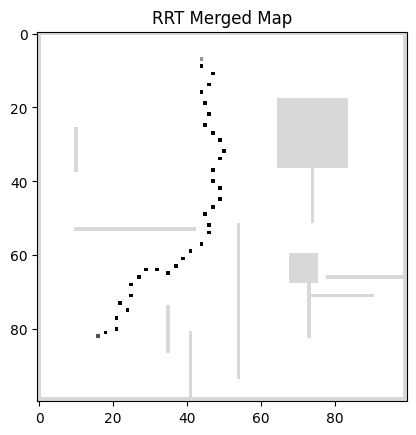

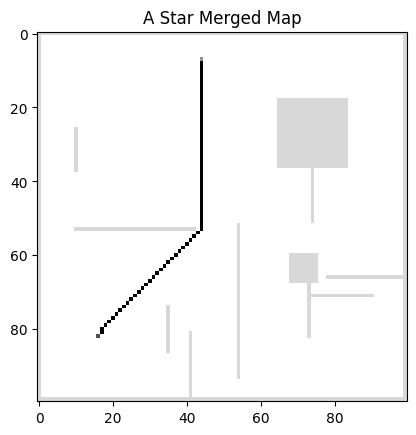

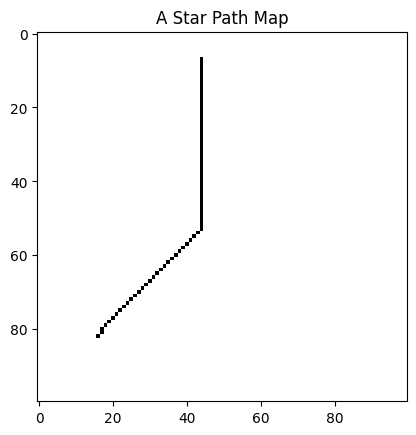

torch.Size([1, 100, 100])

In [ ]:
# Get a batch of data
# data = next(iter(dataloader))
# maps = data['map']

# # Modify the maps with the RRT paths
# modified_maps = []
# for i in range(maps.size(0)):
#     modified_map_rrt = modify_map_with_path(maps[i].numpy(), data['rrt_path'][i].numpy())
#     modified_map_astar = modify_map_with_path(maps[i].numpy(), data['astar_path'][i].numpy())
#     break

# # The number 4 represents the paths.
# # If you only want to display the paths then zero everything else out.
# # modified_map_rrt[modified_map_rrt != 4] = 0
# # modified_map_astar[modified_map_astar != 4] = 0

# # Visualize the first generated map
# plt.imshow(modified_map_rrt.squeeze(), cmap='Greys')
# plt.title("RRT Merged Map")
# plt.show()

# # Visualize the first generated map
# plt.imshow(modified_map_astar.squeeze(), cmap='Greys')
# plt.title("A Star Merged Map")
# plt.show()

# modified_map_rrt.shape


data = next(iter(dataloader))
rrt_modified_map = data['rrt_modified_map'][0]
astar_modified_map = data['astar_modified_map'][0]
astar_path_map = data['astar_path_map'][0]


# The number 4 represents the paths.
# If you only want to display the paths then zero everything else out.
# modified_map_rrt[modified_map_rrt != 4] = 0
# modified_map_astar[modified_map_astar != 4] = 0

# Visualize the map
plt.imshow(rrt_modified_map.squeeze(), cmap='Greys')
plt.title("RRT Merged Map")
plt.show()

# Visualize the map
plt.imshow(astar_modified_map.squeeze(), cmap='Greys')
plt.title("A Star Merged Map")
plt.show()

# Visualize the first generated map
plt.imshow(astar_path_map.squeeze(), cmap='Greys')
plt.title("A Star Path Map")
plt.show()

astar_modified_map.shape

## Generator

In [ ]:
def downsample(in_channels, out_channels, kernel_size=3, apply_batchnorm=True):
    # Downsample layer reduces the spatial dimensions using Conv2D
    # Batch normalization is optional and is used to stabilize and speed up training
    # LeakyReLU activation allows a small gradient when the unit is inactive
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False)]
    if apply_batchnorm:
        layers.append(nn.BatchNorm2d(out_channels))  # Normalize for every mini-batch
    layers.append(nn.LeakyReLU(0.2))  # Apply LeakyReLU with negative slope 0.2
    return nn.Sequential(*layers)

def upsample(in_channels, out_channels, kernel_size=3, apply_dropout=False):
    # Upsample layer increases the spatial dimensions using ConvTranspose2d
    # Batch normalization normalizes outputs from the convolutional layer
    # ReLU activation introduces non-linearity
    # Dropout is used to prevent overfitting
    layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False),
              nn.BatchNorm2d(out_channels),  # Normalize for every mini-batch
              nn.ReLU()]  # Apply ReLU activation function
    if apply_dropout:
        layers.append(nn.Dropout(0.5))  # Apply dropout with probability 0.5
    return nn.Sequential(*layers)

# class UNetGenerator(nn.Module):
#     def __init__(self, input_channels, output_channels):
#         super(UNetGenerator, self).__init__()
#         # Downsample layers: progressively reduce the spatial dimension and increase the depth
#         # Define downsample layers with batch normalization
#         self.down1 = downsample(input_channels, 64, apply_batchnorm=False) # First layer without batchnorm
#         self.down2 = downsample(64, 128)
#         self.down3 = downsample(128, 256)
#         self.down4 = downsample(256, 512)

#         # Define downsample layers without batch normalization for smaller feature maps
#         self.down5 = downsample(512, 512, apply_batchnorm=False)
#         self.down6 = downsample(512, 512, apply_batchnorm=False)
#         self.down7 = downsample(512, 512, apply_batchnorm=False)
#         self.down8 = downsample(512, 512, apply_batchnorm=False)

#         self.down2 = downsample(64, 128)
#         self.down3 = downsample(128, 256)
#         self.down4 = downsample(256, 512)
#         self.down5 = downsample(512, 512)
#         self.down6 = downsample(512, 512)
#         self.down7 = downsample(512, 512)
#         self.down8 = downsample(512, 512)  # Deepest layer

#         # Upsample layers: progressively increase the spatial dimension and decrease the depth
#         self.up1 = upsample(512, 512, apply_dropout=True)  # Start with dropout
#         self.up2 = upsample(1024, 512, apply_dropout=True)
#         self.up3 = upsample(1024, 512, apply_dropout=True)
#         self.up4 = upsample(1024, 512)
#         self.up5 = upsample(1024, 256)
#         self.up6 = upsample(512, 128)
#         self.up7 = upsample(256, 64)

#         # Final layer to output a single channel
#         self.final = nn.ConvTranspose2d(128, output_channels, 3, stride=1, padding=1)


#     def forward(self, x):
#         # Apply downsampling and store intermediate outputs for skip connections
#         d1 = self.down1(x)
#         d2 = self.down2(d1)
#         d3 = self.down3(d2)
#         d4 = self.down4(d3)
#         d5 = self.down5(d4)
#         d6 = self.down6(d5)
#         d7 = self.down7(d6)
#         d8 = self.down8(d7)

#         # Apply upsampling and concatenate with corresponding downsample outputs
#         u1 = self.up1(d8)
#         u2 = self.up2(torch.cat([u1, d7], dim=1))  # Concatenate along channel dimension
#         u3 = self.up3(torch.cat([u2, d6], dim=1))
#         u4 = self.up4(torch.cat([u3, d5], dim=1))
#         u5 = self.up5(torch.cat([u4, d4], dim=1))
#         u6 = self.up6(torch.cat([u5, d3], dim=1))
#         u7 = self.up7(torch.cat([u6, d2], dim=1))

#         # Apply the final layer and Tanh activation
#         out = self.final(torch.cat([u7, d1], dim=1))  # Concatenate with the first downsample output
#         out = torch.tanh(out)  # Tanh to ensure output is in range [-1, 1]

#         # Rescale output to be in the range [0, 4]
#         out_rescaled = (out + 1) * 2  # Scale and shift to [0, 4]

#         # Discretize to nearest integer
#         discretized_output = torch.round(out_rescaled)

#         # Clamp to ensure values are within the range [0, 4]
#         discretized_output = torch.clamp(discretized_output, 0, 4)

#         return discretized_output


class UNetGenerator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(UNetGenerator, self).__init__()

        # Define a simpler downsample and upsample process
        self.down1 = downsample(input_channels, 32, apply_batchnorm=False)
        self.down2 = downsample(32, 64)
        self.down3 = downsample(64, 128)

        self.up1 = upsample(128, 64)
        self.up2 = upsample(128, 32)
        self.up3 = upsample(64, output_channels)

    def forward(self, x):
        # Downsampling
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)

        # Upsampling and skip connections
        u1 = self.up1(d3)
        u2 = self.up2(torch.cat([u1, d2], dim=1))
        u3 = self.up3(torch.cat([u2, d1], dim=1))

        # Final layer, output without sigmoid for adversarial loss calculation
        out_logits = u3

        # Apply sigmoid for reconstruction loss and actual output
        out = torch.sigmoid(out_logits)

        # Since output is binary, we can round it to get 0 or 1 values
        out_binary = torch.round(out)

        return out, out_binary, out_logits

# Example usage
input_channels = 1  # Assuming grayscale input maps
output_channels = 1  # Assuming grayscale output maps
generator = UNetGenerator(input_channels, output_channels)


# This is the architecture:
# d1 shape: torch.Size([1, 64, 100, 100])
# d2 shape: torch.Size([1, 128, 100, 100])
# d3 shape: torch.Size([1, 256, 100, 100])
# d4 shape: torch.Size([1, 512, 100, 100])
# d5 shape: torch.Size([1, 512, 100, 100])
# d6 shape: torch.Size([1, 512, 100, 100])
# d7 shape: torch.Size([1, 512, 100, 100])
# d8 shape: torch.Size([1, 512, 100, 100])
# u1 shape: torch.Size([1, 512, 100, 100])
# u2 shape: torch.Size([1, 512, 100, 100])
# u3 shape: torch.Size([1, 512, 100, 100])
# u4 shape: torch.Size([1, 512, 100, 100])
# u5 shape: torch.Size([1, 256, 100, 100])
# u6 shape: torch.Size([1, 128, 100, 100])
# u7 shape: torch.Size([1, 64, 100, 100])
# out shape: torch.Size([1, 1, 100, 100])

Test the output of the generator on a random map

Generated output Shape: torch.Size([1, 1, 100, 100])


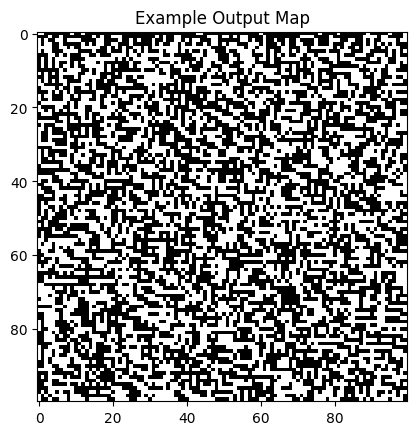

tensor([[[[0.5000, 0.5000, 0.6814,  ..., 0.6415, 0.6672, 0.5000],
          [0.7326, 0.6551, 0.8685,  ..., 0.7684, 0.5710, 0.5000],
          [0.5000, 0.7774, 0.5000,  ..., 0.8365, 0.5000, 0.5000],
          ...,
          [0.5609, 0.5000, 0.7193,  ..., 0.7347, 0.5000, 0.5000],
          [0.5000, 0.6675, 0.5000,  ..., 0.6583, 0.5000, 0.5885],
          [0.5000, 0.5427, 0.5331,  ..., 0.5000, 0.5000, 0.6017]]]],
       grad_fn=<SigmoidBackward0>)

In [ ]:
# Visualize the first generated map
test_input = torch.randn(1, input_channels, 100, 100)  # Example input
output, output_binary, out_logits = generator(test_input)
print(f"Generated output Shape: {output.shape}")

plt.imshow(output_binary.squeeze().detach().numpy(), cmap='Greys')
plt.title("Example Output Map")
plt.show()
output

Plot function to help visualize the maps and generated paths.

In [ ]:
# Get a batch of data
# data = next(iter(dataloader))
# maps = data['map']

# # Modify the maps with the RRT paths
# modified_maps = []
# for i in range(maps.size(0)):
#     modified_map_rrt = modify_map_with_path(maps[i].numpy(), data['rrt_path'][i].numpy())
#     modified_map_astar = modify_map_with_path(maps[i].numpy(), data['astar_path'][i].numpy())
#     break


def plot_maps(rrt_map, astar_map, astar_path_map, generated_path):
    # Visualize the original and generated maps
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    # Move the tensor back to CPU and convert it to NumPy for visualization
    plt.imshow(rrt_map_tensor.squeeze().cpu().numpy(), cmap='Greys')
    plt.title("RRT Path")
    # plt.colorbar()

    # plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 2)
    # Move the tensor back to CPU and convert it to NumPy for visualization
    plt.imshow(astar_map_tensor.squeeze().cpu().numpy(), cmap='Greys')
    plt.title("A* Path and Map")
    # plt.colorbar()

    # plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 3)
    # Move the tensor back to CPU and convert it to NumPy for visualization
    plt.imshow(astar_path_map_tensor.squeeze().cpu().numpy(), cmap='Greys')
    plt.title("A* Path")
    # plt.colorbar()

    # plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 4)
    # Move the tensor back to CPU and convert it to NumPy for visualization
    plt.imshow(generated_output_binary.squeeze().cpu().numpy(), cmap='Greys')
    plt.title("Generated Path")
    # plt.colorbar()

    plt.savefig('../captures/training_start0.png', dpi=500)
    plt.show()


Test the generator on real RRT Paths and Visualize

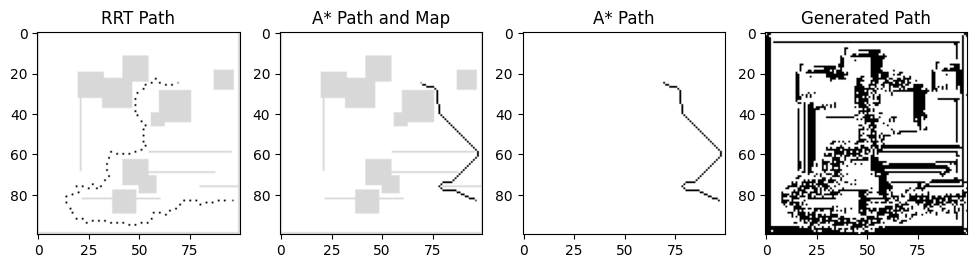

In [ ]:
data = next(iter(dataloader))
rrt_modified_map = data['rrt_modified_map'][0].squeeze()
astar_modified_map = data['astar_modified_map'][0].squeeze()
astar_path_map = data['astar_path_map'][0].squeeze()

# Use clone().detach() instead of torch.tensor() for existing tensors
rrt_map_tensor = rrt_modified_map.clone().detach().unsqueeze(0).unsqueeze(0).float()
astar_map_tensor = astar_modified_map.clone().detach().unsqueeze(0).unsqueeze(0).float()
astar_path_map_tensor = astar_path_map.clone().detach().unsqueeze(0).unsqueeze(0).float()

# Check if GPU is available and move the tensor to GPU for faster computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rrt_map_tensor = rrt_map_tensor.to(device)
generator = generator.to(device)

# Generate the output map
with torch.no_grad():  # No need to track gradients
    generated_output, generated_output_binary, _ = generator(rrt_map_tensor)

plot_maps(rrt_map_tensor, astar_map_tensor, astar_path_map_tensor, generated_output_binary)

GAN Loss Function

In [ ]:
# Adversarial loss (Binary Cross Entropy with Logits)
adversarial_loss = nn.BCEWithLogitsLoss()

# Reconstruction loss (Binary Cross Entropy)
reconstruction_loss = nn.BCELoss()

def generator_loss(disc_generated_output, gen_output, target):
    """
    Calculate the generator's loss.

    Parameters:
    - disc_generated_output: output from the discriminator for generated images
    - gen_output: generated maps from the generator (logits)
    - target: real A* maps (binary)

    Returns:
    - total_gen_loss: the total loss for the generator
    """
    # Adversarial loss: how well the generator was able to trick the discriminator
    real_labels = torch.ones_like(disc_generated_output)
    gen_adv_loss = adversarial_loss(disc_generated_output, real_labels)

    # Convert gen_output logits to probabilities using sigmoid
    gen_output_probs = torch.sigmoid(gen_output)

    # Reconstruction loss: how similar the generated map (probabilities) is to the real map (binary)
    gen_recon_loss = reconstruction_loss(gen_output_probs, target)

    # Total generator loss
    alpha = 2  # weight for reconstruction loss
    total_gen_loss = gen_adv_loss + alpha * gen_recon_loss

    return total_gen_loss

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Define the architecture of the PatchGAN discriminator
        self.model = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # Second convolutional layer
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Third convolutional layer
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Fourth convolutional layer
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),  # Stride of 1 to maintain patch size
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer to a patch output
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Produces a 30x30 patch grid
        )

    def forward(self, map1, map2):
        # Concatenate the two input maps along the channel dimension
        combined_input = torch.cat([map1, map2], dim=1)
        # Forward pass through the network to produce a patch grid
        patch_out = self.model(combined_input)
        return patch_out

Discriminator Loss

In [ ]:
# Binary Cross-Entropy loss with logits
# This loss combines a Sigmoid layer and the BCELoss in one single class
criterion = nn.BCEWithLogitsLoss()

def discriminator_loss(disc_real_output, disc_generated_output):
    """
    Calculate discriminator loss.

    Args:
    - disc_real_output (tensor): Discriminator output for real data.
    - disc_generated_output (tensor): Discriminator output for generated (fake) data.

    Returns:
    - total_disc_loss (tensor): Total loss for the discriminator.
    """
    # Real loss - how well the discriminator classifies real images
    real_loss = criterion(disc_real_output, torch.ones_like(disc_real_output))

    # Generated loss - how well the discriminator classifies generated images
    generated_loss = criterion(disc_generated_output, torch.zeros_like(disc_generated_output))

    # Total discriminator loss
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

# Training

Check for CUDA

In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


Best Model Saved at Gen_Loss: 2.7718052864074707.
Best Model Saved at Gen_Loss: 2.6104397773742676.
Best Model Saved at Gen_Loss: 2.503624677658081.
Best Model Saved at Gen_Loss: 2.4639854431152344.
Best Model Saved at Gen_Loss: 2.441256284713745.
Best Model Saved at Gen_Loss: 2.4149177074432373.
Best Model Saved at Gen_Loss: 2.4073398113250732.
Best Model Saved at Gen_Loss: 2.3813271522521973.
Best Model Saved at Gen_Loss: 2.3745687007904053.
Best Model Saved at Gen_Loss: 2.2750160694122314.
Best Model Saved at Gen_Loss: 2.235440731048584.
Best Model Saved at Gen_Loss: 2.1881651878356934.
Epoch [1/1000], Total Steps: 32, G Total Loss: 2.400617837905884, D Loss: 1.3880515098571777
Best Model Saved at Gen_Loss: 2.166254997253418.
Best Model Saved at Gen_Loss: 2.1063833236694336.
Best Model Saved at Gen_Loss: 2.087944984436035.
Best Model Saved at Gen_Loss: 2.0784432888031006.
Best Model Saved at Gen_Loss: 2.0686662197113037.
Best Model Saved at Gen_Loss: 2.038761615753174.
Epoch [2/1000

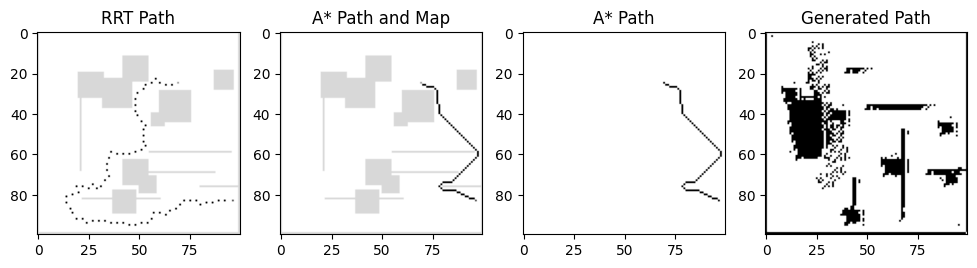

Epoch [11/1000], Total Steps: 352, G Total Loss: 2.3732175827026367, D Loss: 1.3697460889816284
Epoch [12/1000], Total Steps: 384, G Total Loss: 2.3694422245025635, D Loss: 1.3890639543533325
Epoch [13/1000], Total Steps: 416, G Total Loss: 2.2488174438476562, D Loss: 1.382775068283081
Epoch [14/1000], Total Steps: 448, G Total Loss: 2.4612233638763428, D Loss: 1.3437020778656006
Epoch [15/1000], Total Steps: 480, G Total Loss: 2.624086618423462, D Loss: 1.3465023040771484
Epoch [16/1000], Total Steps: 512, G Total Loss: 2.3788580894470215, D Loss: 1.287748098373413
Epoch [17/1000], Total Steps: 544, G Total Loss: 2.365602970123291, D Loss: 1.354248285293579
Epoch [18/1000], Total Steps: 576, G Total Loss: 2.6307570934295654, D Loss: 1.3470098972320557
Epoch [19/1000], Total Steps: 608, G Total Loss: 2.3768434524536133, D Loss: 1.2689123153686523
Epoch [20/1000], Total Steps: 640, G Total Loss: 2.454860210418701, D Loss: 1.3430607318878174
Checkpoint saved at epoch 20.


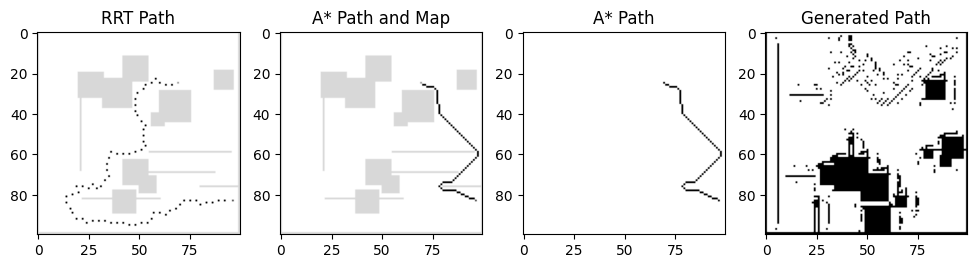

Epoch [21/1000], Total Steps: 672, G Total Loss: 2.450134515762329, D Loss: 1.2554686069488525
Epoch [22/1000], Total Steps: 704, G Total Loss: 2.3330092430114746, D Loss: 1.3827548027038574
Epoch [23/1000], Total Steps: 736, G Total Loss: 2.474337100982666, D Loss: 1.3625781536102295
Epoch [24/1000], Total Steps: 768, G Total Loss: 2.5579988956451416, D Loss: 1.225320816040039
Best Model Saved at Gen_Loss: 1.9838372468948364.
Best Model Saved at Gen_Loss: 1.9675506353378296.
Epoch [25/1000], Total Steps: 800, G Total Loss: 2.553812026977539, D Loss: 1.0012357234954834
Epoch [26/1000], Total Steps: 832, G Total Loss: 2.5839858055114746, D Loss: 0.9920822381973267
Epoch [27/1000], Total Steps: 864, G Total Loss: 3.4056873321533203, D Loss: 1.2441651821136475
Epoch [28/1000], Total Steps: 896, G Total Loss: 2.359004020690918, D Loss: 1.1401047706604004
Epoch [29/1000], Total Steps: 928, G Total Loss: 3.331007957458496, D Loss: 0.9573397636413574
Best Model Saved at Gen_Loss: 1.9352557659

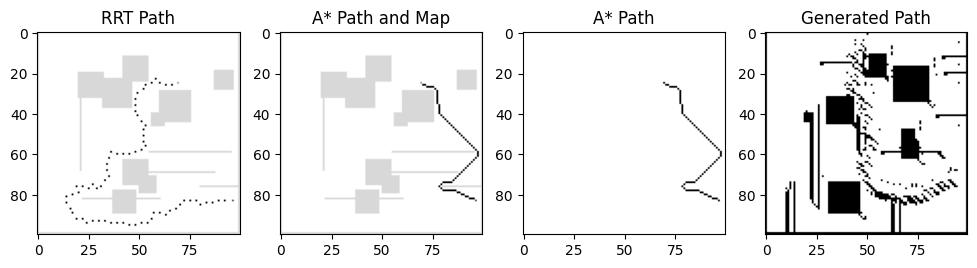

Epoch [31/1000], Total Steps: 992, G Total Loss: 2.600998640060425, D Loss: 1.0878307819366455
Epoch [32/1000], Total Steps: 1024, G Total Loss: 2.713015556335449, D Loss: 1.1218810081481934
Epoch [33/1000], Total Steps: 1056, G Total Loss: 2.1569364070892334, D Loss: 1.2557148933410645
Epoch [34/1000], Total Steps: 1088, G Total Loss: 2.9497194290161133, D Loss: 0.9121119976043701
Epoch [35/1000], Total Steps: 1120, G Total Loss: 2.421971559524536, D Loss: 0.936217188835144
Epoch [36/1000], Total Steps: 1152, G Total Loss: 2.6995747089385986, D Loss: 1.1117126941680908
Epoch [37/1000], Total Steps: 1184, G Total Loss: 2.7639992237091064, D Loss: 1.1430761814117432
Epoch [38/1000], Total Steps: 1216, G Total Loss: 2.3444528579711914, D Loss: 0.8160474300384521
Epoch [39/1000], Total Steps: 1248, G Total Loss: 3.3396682739257812, D Loss: 1.181888222694397
Epoch [40/1000], Total Steps: 1280, G Total Loss: 3.151369094848633, D Loss: 0.9733107089996338
Checkpoint saved at epoch 40.


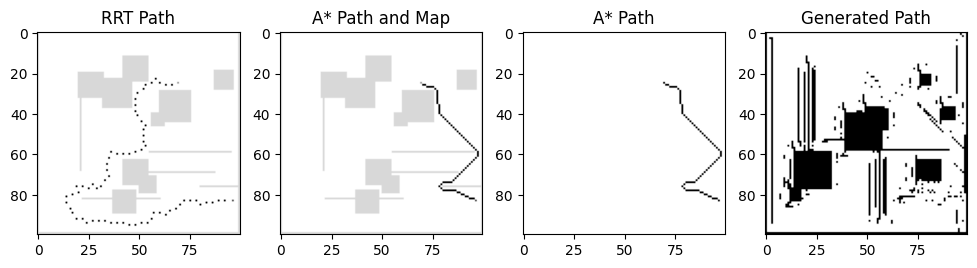

Epoch [41/1000], Total Steps: 1312, G Total Loss: 3.8992934226989746, D Loss: 0.6710506677627563
Epoch [42/1000], Total Steps: 1344, G Total Loss: 2.655338764190674, D Loss: 1.085299015045166
Epoch [43/1000], Total Steps: 1376, G Total Loss: 2.865790367126465, D Loss: 1.2886848449707031
Epoch [44/1000], Total Steps: 1408, G Total Loss: 3.8534069061279297, D Loss: 0.9680725336074829
Epoch [45/1000], Total Steps: 1440, G Total Loss: 3.0868258476257324, D Loss: 0.7792589664459229
Epoch [46/1000], Total Steps: 1472, G Total Loss: 2.9147908687591553, D Loss: 0.7388160228729248
Epoch [47/1000], Total Steps: 1504, G Total Loss: 3.345611333847046, D Loss: 0.6681877374649048
Epoch [48/1000], Total Steps: 1536, G Total Loss: 2.182588815689087, D Loss: 1.1352193355560303
Epoch [49/1000], Total Steps: 1568, G Total Loss: 2.8608784675598145, D Loss: 0.720429539680481
Epoch [50/1000], Total Steps: 1600, G Total Loss: 2.430894613265991, D Loss: 1.0795702934265137
Checkpoint saved at epoch 50.


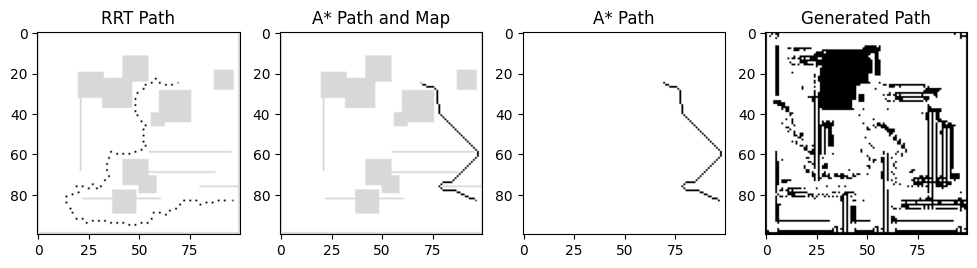

Epoch [51/1000], Total Steps: 1632, G Total Loss: 2.8833279609680176, D Loss: 1.0954935550689697
Epoch [52/1000], Total Steps: 1664, G Total Loss: 3.731536865234375, D Loss: 0.8075442910194397
Epoch [53/1000], Total Steps: 1696, G Total Loss: 2.7395477294921875, D Loss: 1.0186222791671753
Epoch [54/1000], Total Steps: 1728, G Total Loss: 3.4842031002044678, D Loss: 0.6644327640533447
Epoch [55/1000], Total Steps: 1760, G Total Loss: 2.758645534515381, D Loss: 1.002150297164917
Epoch [56/1000], Total Steps: 1792, G Total Loss: 2.222193717956543, D Loss: 0.9811134934425354
Epoch [57/1000], Total Steps: 1824, G Total Loss: 3.411470413208008, D Loss: 0.6523089408874512
Epoch [58/1000], Total Steps: 1856, G Total Loss: 4.162559986114502, D Loss: 0.6079393029212952
Epoch [59/1000], Total Steps: 1888, G Total Loss: 3.4888064861297607, D Loss: 0.698573112487793
Epoch [60/1000], Total Steps: 1920, G Total Loss: 3.1983628273010254, D Loss: 1.150886058807373
Checkpoint saved at epoch 60.


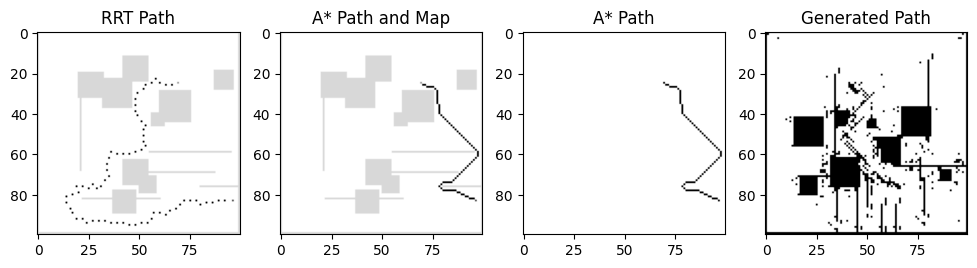

Epoch [61/1000], Total Steps: 1952, G Total Loss: 4.429905891418457, D Loss: 0.8832387924194336
Best Model Saved at Gen_Loss: 1.8121871948242188.
Best Model Saved at Gen_Loss: 1.8115640878677368.
Epoch [62/1000], Total Steps: 1984, G Total Loss: 2.3753840923309326, D Loss: 1.693230152130127
Epoch [63/1000], Total Steps: 2016, G Total Loss: 3.7576489448547363, D Loss: 0.7648379802703857
Epoch [64/1000], Total Steps: 2048, G Total Loss: 3.7689499855041504, D Loss: 0.90190190076828
Epoch [65/1000], Total Steps: 2080, G Total Loss: 2.9232821464538574, D Loss: 0.5291787385940552
Epoch [66/1000], Total Steps: 2112, G Total Loss: 4.127559661865234, D Loss: 0.4002023935317993
Epoch [67/1000], Total Steps: 2144, G Total Loss: 4.074498653411865, D Loss: 0.36127790808677673
Epoch [68/1000], Total Steps: 2176, G Total Loss: 2.9727797508239746, D Loss: 0.6458000540733337
Epoch [69/1000], Total Steps: 2208, G Total Loss: 2.772127628326416, D Loss: 0.35474374890327454
Epoch [70/1000], Total Steps: 22

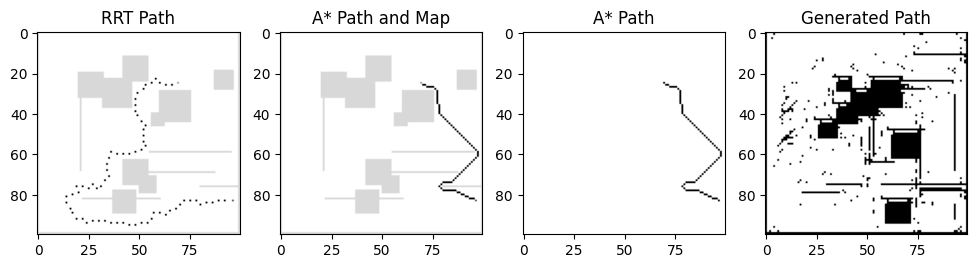

Epoch [71/1000], Total Steps: 2272, G Total Loss: 4.434817314147949, D Loss: 0.26211753487586975
Epoch [72/1000], Total Steps: 2304, G Total Loss: 4.389456272125244, D Loss: 0.28855305910110474
Epoch [73/1000], Total Steps: 2336, G Total Loss: 2.580085277557373, D Loss: 0.9379943013191223
Epoch [74/1000], Total Steps: 2368, G Total Loss: 2.92148494720459, D Loss: 0.6632469892501831
Epoch [75/1000], Total Steps: 2400, G Total Loss: 4.905055999755859, D Loss: 0.30688026547431946
Epoch [76/1000], Total Steps: 2432, G Total Loss: 4.718002796173096, D Loss: 0.7001913785934448
Epoch [77/1000], Total Steps: 2464, G Total Loss: 4.814812660217285, D Loss: 0.5976654291152954
Epoch [78/1000], Total Steps: 2496, G Total Loss: 2.282439947128296, D Loss: 0.767084002494812
Epoch [79/1000], Total Steps: 2528, G Total Loss: 3.919445753097534, D Loss: 0.23305675387382507
Epoch [80/1000], Total Steps: 2560, G Total Loss: 5.088234901428223, D Loss: 0.30534398555755615
Checkpoint saved at epoch 80.


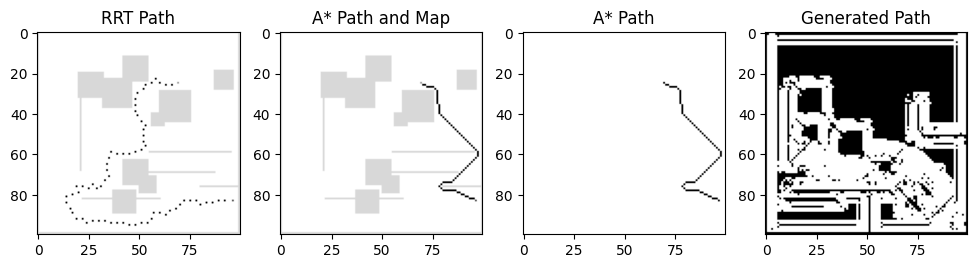

Epoch [81/1000], Total Steps: 2592, G Total Loss: 6.706690311431885, D Loss: 0.49903184175491333
Epoch [82/1000], Total Steps: 2624, G Total Loss: 4.377959251403809, D Loss: 1.0778189897537231
Epoch [83/1000], Total Steps: 2656, G Total Loss: 2.6007938385009766, D Loss: 1.4216845035552979
Epoch [84/1000], Total Steps: 2688, G Total Loss: 4.303185939788818, D Loss: 0.4043683111667633
Epoch [85/1000], Total Steps: 2720, G Total Loss: 3.052913188934326, D Loss: 0.7543512582778931
Epoch [86/1000], Total Steps: 2752, G Total Loss: 4.470008850097656, D Loss: 0.3318865895271301
Epoch [87/1000], Total Steps: 2784, G Total Loss: 2.6694295406341553, D Loss: 0.6787394285202026
Epoch [88/1000], Total Steps: 2816, G Total Loss: 2.9775938987731934, D Loss: 1.4940437078475952
Epoch [89/1000], Total Steps: 2848, G Total Loss: 3.2008376121520996, D Loss: 0.1629275381565094
Epoch [90/1000], Total Steps: 2880, G Total Loss: 5.127211093902588, D Loss: 0.14446091651916504
Checkpoint saved at epoch 90.


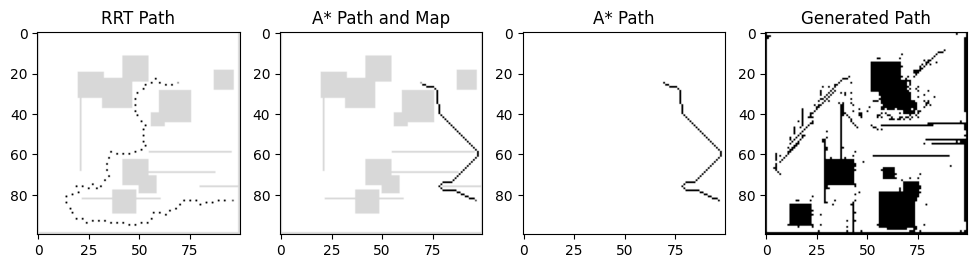

Epoch [91/1000], Total Steps: 2912, G Total Loss: 4.705296993255615, D Loss: 0.2880609929561615
Epoch [92/1000], Total Steps: 2944, G Total Loss: 4.3556413650512695, D Loss: 0.3854329586029053
Epoch [93/1000], Total Steps: 2976, G Total Loss: 5.219771385192871, D Loss: 0.43649420142173767
Epoch [94/1000], Total Steps: 3008, G Total Loss: 4.952346324920654, D Loss: 0.23420485854148865
Epoch [95/1000], Total Steps: 3040, G Total Loss: 5.969699859619141, D Loss: 0.08455540984869003
Epoch [96/1000], Total Steps: 3072, G Total Loss: 5.0118794441223145, D Loss: 0.08326555788516998
Epoch [97/1000], Total Steps: 3104, G Total Loss: 4.820611953735352, D Loss: 0.07479323446750641
Epoch [98/1000], Total Steps: 3136, G Total Loss: 5.634965896606445, D Loss: 0.04485470429062843
Epoch [99/1000], Total Steps: 3168, G Total Loss: 6.785938739776611, D Loss: 0.07274778187274933
Epoch [100/1000], Total Steps: 3200, G Total Loss: 3.3367905616760254, D Loss: 0.20220179855823517
Checkpoint saved at epoch 10

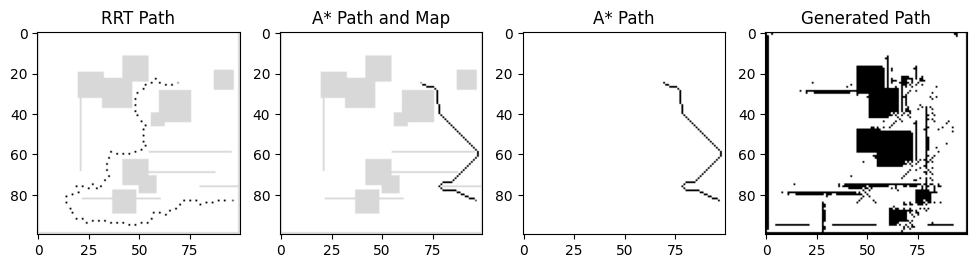

Epoch [101/1000], Total Steps: 3232, G Total Loss: 4.841279029846191, D Loss: 0.09148222208023071
Epoch [102/1000], Total Steps: 3264, G Total Loss: 5.802628040313721, D Loss: 0.11019248515367508
Epoch [103/1000], Total Steps: 3296, G Total Loss: 5.134311676025391, D Loss: 0.09261788427829742
Epoch [104/1000], Total Steps: 3328, G Total Loss: 5.55281925201416, D Loss: 0.10085485875606537
Epoch [105/1000], Total Steps: 3360, G Total Loss: 5.979278564453125, D Loss: 0.06578407436609268
Epoch [106/1000], Total Steps: 3392, G Total Loss: 3.871696710586548, D Loss: 0.06221047043800354
Epoch [107/1000], Total Steps: 3424, G Total Loss: 5.764339447021484, D Loss: 0.0693255364894867
Epoch [108/1000], Total Steps: 3456, G Total Loss: 6.08815336227417, D Loss: 0.08757497370243073
Epoch [109/1000], Total Steps: 3488, G Total Loss: 6.2126030921936035, D Loss: 0.03822748735547066
Epoch [110/1000], Total Steps: 3520, G Total Loss: 5.521216869354248, D Loss: 0.13428904116153717
Checkpoint saved at ep

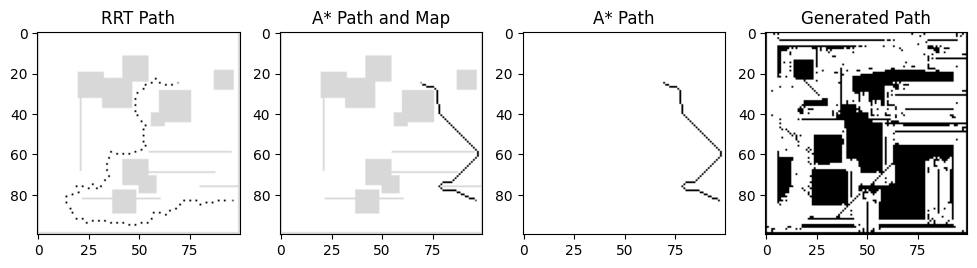

Epoch [111/1000], Total Steps: 3552, G Total Loss: 4.073956489562988, D Loss: 0.12447376549243927
Epoch [112/1000], Total Steps: 3584, G Total Loss: 6.465714454650879, D Loss: 0.0387268103659153
Epoch [113/1000], Total Steps: 3616, G Total Loss: 5.748723030090332, D Loss: 0.052823424339294434
Epoch [114/1000], Total Steps: 3648, G Total Loss: 5.951671600341797, D Loss: 0.03906897082924843
Epoch [115/1000], Total Steps: 3680, G Total Loss: 6.7454752922058105, D Loss: 0.03774302080273628
Epoch [116/1000], Total Steps: 3712, G Total Loss: 5.9584150314331055, D Loss: 0.030496597290039062
Epoch [117/1000], Total Steps: 3744, G Total Loss: 6.213390827178955, D Loss: 0.20921313762664795
Epoch [118/1000], Total Steps: 3776, G Total Loss: 7.586289405822754, D Loss: 0.8188899159431458
Epoch [119/1000], Total Steps: 3808, G Total Loss: 6.008902549743652, D Loss: 0.4399648904800415
Epoch [120/1000], Total Steps: 3840, G Total Loss: 5.991570472717285, D Loss: 0.17439858615398407
Checkpoint saved at

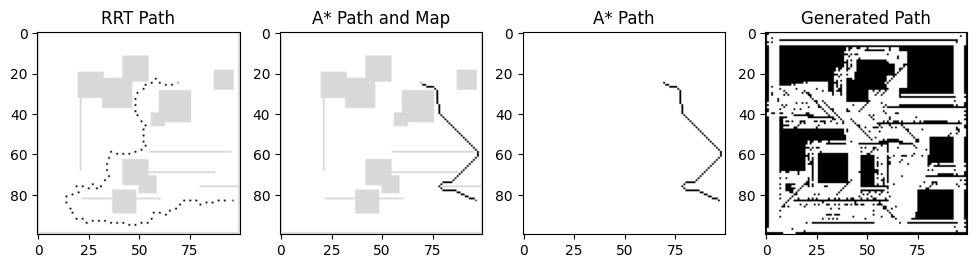

Epoch [121/1000], Total Steps: 3872, G Total Loss: 6.262791633605957, D Loss: 0.11993516981601715
Epoch [122/1000], Total Steps: 3904, G Total Loss: 5.072455883026123, D Loss: 0.05693049728870392
Epoch [123/1000], Total Steps: 3936, G Total Loss: 5.4687957763671875, D Loss: 0.17751039564609528
Epoch [124/1000], Total Steps: 3968, G Total Loss: 4.691766262054443, D Loss: 0.15858244895935059
Epoch [125/1000], Total Steps: 4000, G Total Loss: 7.282047748565674, D Loss: 0.07313691079616547
Epoch [126/1000], Total Steps: 4032, G Total Loss: 7.330714225769043, D Loss: 0.11776641011238098
Epoch [127/1000], Total Steps: 4064, G Total Loss: 8.058886528015137, D Loss: 0.16155073046684265
Epoch [128/1000], Total Steps: 4096, G Total Loss: 1.9721593856811523, D Loss: 3.0243449211120605
Epoch [129/1000], Total Steps: 4128, G Total Loss: 3.010558605194092, D Loss: 0.9673643112182617
Epoch [130/1000], Total Steps: 4160, G Total Loss: 5.076399803161621, D Loss: 0.33847925066947937
Checkpoint saved at 

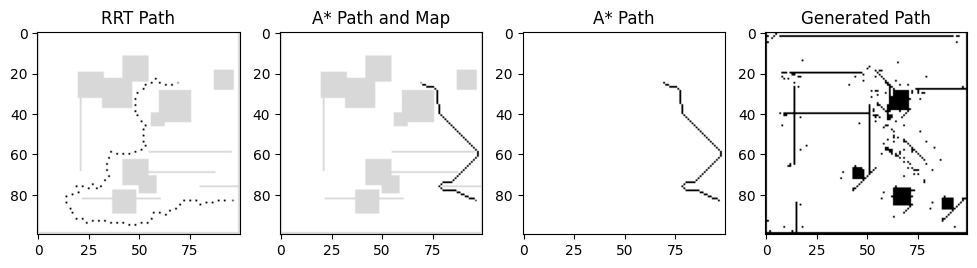

Epoch [131/1000], Total Steps: 4192, G Total Loss: 3.4130783081054688, D Loss: 0.5566970705986023
Epoch [132/1000], Total Steps: 4224, G Total Loss: 4.6155104637146, D Loss: 0.9320923686027527
Epoch [133/1000], Total Steps: 4256, G Total Loss: 4.0646467208862305, D Loss: 0.23935985565185547
Epoch [134/1000], Total Steps: 4288, G Total Loss: 4.423646450042725, D Loss: 0.5034362077713013
Epoch [135/1000], Total Steps: 4320, G Total Loss: 6.623215675354004, D Loss: 0.37741032242774963
Epoch [136/1000], Total Steps: 4352, G Total Loss: 5.979223728179932, D Loss: 0.43470168113708496
Epoch [137/1000], Total Steps: 4384, G Total Loss: 5.274374485015869, D Loss: 0.13483215868473053
Epoch [138/1000], Total Steps: 4416, G Total Loss: 4.55886173248291, D Loss: 0.12283797562122345
Epoch [139/1000], Total Steps: 4448, G Total Loss: 5.5451483726501465, D Loss: 0.15679243206977844
Epoch [140/1000], Total Steps: 4480, G Total Loss: 5.661694526672363, D Loss: 0.0685688704252243
Checkpoint saved at epoc

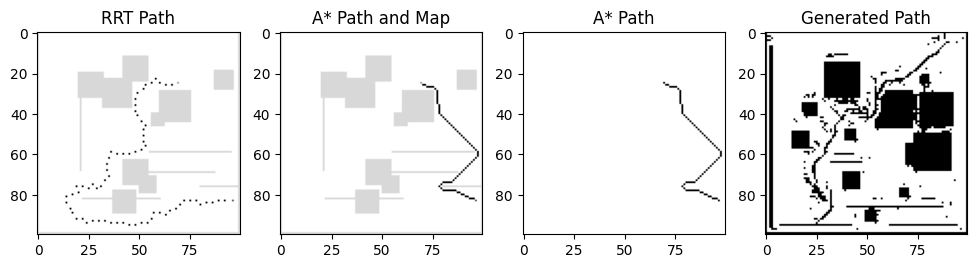

Epoch [141/1000], Total Steps: 4512, G Total Loss: 4.517437934875488, D Loss: 0.12611255049705505
Epoch [142/1000], Total Steps: 4544, G Total Loss: 4.523586273193359, D Loss: 0.14309705793857574
Epoch [143/1000], Total Steps: 4576, G Total Loss: 6.7227349281311035, D Loss: 0.03922383487224579
Epoch [144/1000], Total Steps: 4608, G Total Loss: 7.065574645996094, D Loss: 0.03468015044927597
Epoch [145/1000], Total Steps: 4640, G Total Loss: 6.715124130249023, D Loss: 0.1316710114479065
Epoch [146/1000], Total Steps: 4672, G Total Loss: 6.239485740661621, D Loss: 0.07985178381204605
Epoch [147/1000], Total Steps: 4704, G Total Loss: 6.4192914962768555, D Loss: 0.027380723506212234
Epoch [148/1000], Total Steps: 4736, G Total Loss: 6.797112464904785, D Loss: 0.030559225007891655
Epoch [149/1000], Total Steps: 4768, G Total Loss: 5.176677703857422, D Loss: 0.2683511972427368
Epoch [150/1000], Total Steps: 4800, G Total Loss: 4.317474365234375, D Loss: 0.18410708010196686
Checkpoint saved a

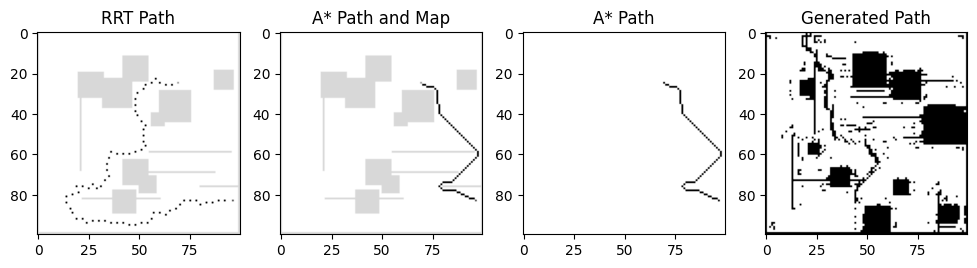

Epoch [151/1000], Total Steps: 4832, G Total Loss: 3.572713613510132, D Loss: 0.11952386051416397
Epoch [152/1000], Total Steps: 4864, G Total Loss: 5.593415260314941, D Loss: 0.23730605840682983
Epoch [153/1000], Total Steps: 4896, G Total Loss: 4.901152610778809, D Loss: 0.15190857648849487
Epoch [154/1000], Total Steps: 4928, G Total Loss: 7.513075351715088, D Loss: 0.10757625102996826
Epoch [155/1000], Total Steps: 4960, G Total Loss: 5.741757392883301, D Loss: 0.047861188650131226
Epoch [156/1000], Total Steps: 4992, G Total Loss: 6.6408491134643555, D Loss: 0.055227093398571014
Epoch [157/1000], Total Steps: 5024, G Total Loss: 6.954302787780762, D Loss: 0.06287828832864761
Epoch [158/1000], Total Steps: 5056, G Total Loss: 7.7039265632629395, D Loss: 0.08411282300949097
Epoch [159/1000], Total Steps: 5088, G Total Loss: 7.440631866455078, D Loss: 0.029974594712257385
Epoch [160/1000], Total Steps: 5120, G Total Loss: 7.656323432922363, D Loss: 0.017853500321507454
Checkpoint sav

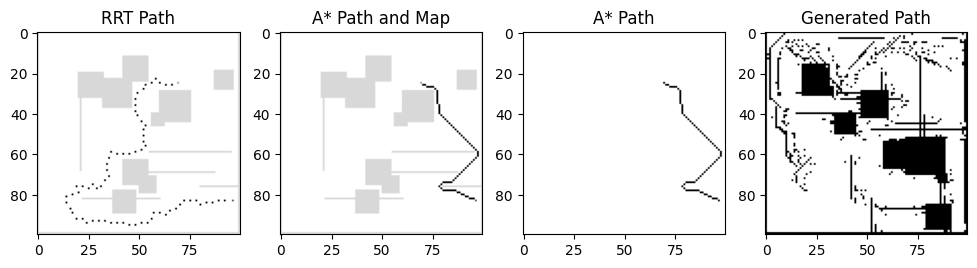

Epoch [161/1000], Total Steps: 5152, G Total Loss: 6.3588056564331055, D Loss: 0.13676181435585022
Epoch [162/1000], Total Steps: 5184, G Total Loss: 5.2910590171813965, D Loss: 0.13697600364685059
Epoch [163/1000], Total Steps: 5216, G Total Loss: 7.331453800201416, D Loss: 0.024678386747837067
Epoch [164/1000], Total Steps: 5248, G Total Loss: 6.549400329589844, D Loss: 0.035935014486312866
Epoch [165/1000], Total Steps: 5280, G Total Loss: 6.716738224029541, D Loss: 0.06958307325839996
Epoch [166/1000], Total Steps: 5312, G Total Loss: 5.960326194763184, D Loss: 0.1749046891927719
Epoch [167/1000], Total Steps: 5344, G Total Loss: 5.655754089355469, D Loss: 0.03765944391489029
Epoch [168/1000], Total Steps: 5376, G Total Loss: 6.56608247756958, D Loss: 0.07454890012741089
Epoch [169/1000], Total Steps: 5408, G Total Loss: 7.17919921875, D Loss: 0.04070930927991867
Epoch [170/1000], Total Steps: 5440, G Total Loss: 8.750519752502441, D Loss: 0.02900484949350357
Checkpoint saved at ep

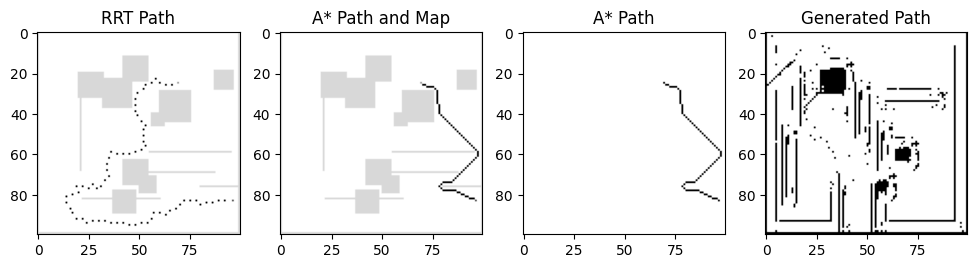

Epoch [171/1000], Total Steps: 5472, G Total Loss: 5.9896345138549805, D Loss: 0.038963086903095245
Epoch [172/1000], Total Steps: 5504, G Total Loss: 6.2715983390808105, D Loss: 0.035888671875
Epoch [173/1000], Total Steps: 5536, G Total Loss: 6.8100080490112305, D Loss: 0.024633919820189476
Epoch [174/1000], Total Steps: 5568, G Total Loss: 8.310835838317871, D Loss: 0.03392643854022026
Epoch [175/1000], Total Steps: 5600, G Total Loss: 6.200773239135742, D Loss: 0.022335991263389587
Epoch [176/1000], Total Steps: 5632, G Total Loss: 8.682820320129395, D Loss: 0.021890847012400627
Epoch [177/1000], Total Steps: 5664, G Total Loss: 7.615012168884277, D Loss: 0.023918520659208298
Epoch [178/1000], Total Steps: 5696, G Total Loss: 4.818652153015137, D Loss: 0.010204141959547997
Epoch [179/1000], Total Steps: 5728, G Total Loss: 8.29308032989502, D Loss: 0.014917448163032532
Epoch [180/1000], Total Steps: 5760, G Total Loss: 7.303879737854004, D Loss: 0.02494768612086773
Checkpoint saved

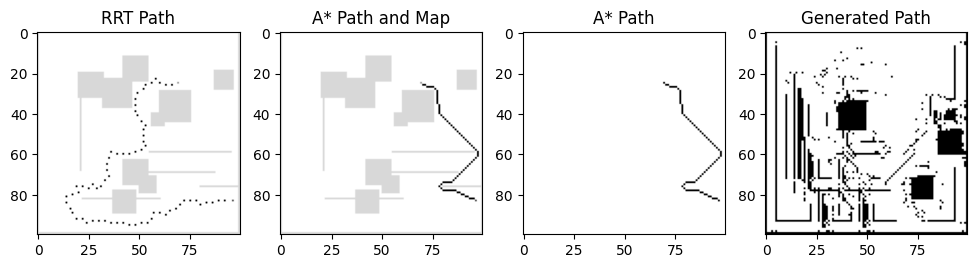

Epoch [181/1000], Total Steps: 5792, G Total Loss: 6.553763389587402, D Loss: 0.022022750228643417
Epoch [182/1000], Total Steps: 5824, G Total Loss: 7.685255527496338, D Loss: 0.044040028005838394
Epoch [183/1000], Total Steps: 5856, G Total Loss: 4.534728527069092, D Loss: 0.032335661351680756
Epoch [184/1000], Total Steps: 5888, G Total Loss: 8.480701446533203, D Loss: 0.01356499269604683
Epoch [185/1000], Total Steps: 5920, G Total Loss: 7.5400824546813965, D Loss: 0.014916525222361088
Epoch [186/1000], Total Steps: 5952, G Total Loss: 6.721726894378662, D Loss: 0.015085061080753803
Epoch [187/1000], Total Steps: 5984, G Total Loss: 9.094459533691406, D Loss: 0.010393010452389717
Epoch [188/1000], Total Steps: 6016, G Total Loss: 8.004545211791992, D Loss: 0.007960604503750801
Epoch [189/1000], Total Steps: 6048, G Total Loss: 6.0855817794799805, D Loss: 0.013430812396109104
Epoch [190/1000], Total Steps: 6080, G Total Loss: 7.728550910949707, D Loss: 0.032912857830524445
Checkpoin

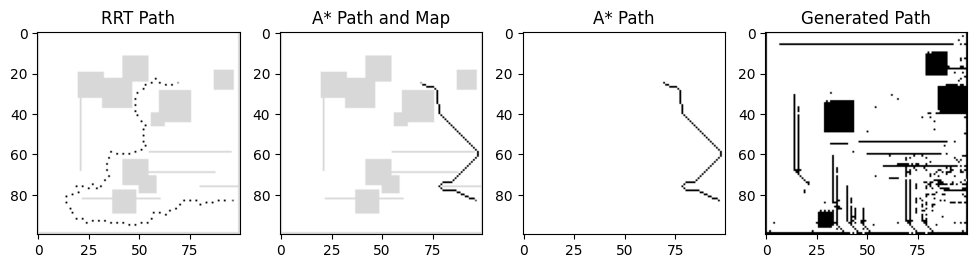

Epoch [191/1000], Total Steps: 6112, G Total Loss: 7.742583274841309, D Loss: 0.029102733358740807
Epoch [192/1000], Total Steps: 6144, G Total Loss: 7.3567609786987305, D Loss: 0.02739538997411728
Epoch [193/1000], Total Steps: 6176, G Total Loss: 6.678309917449951, D Loss: 0.013583424501121044
Epoch [194/1000], Total Steps: 6208, G Total Loss: 7.8317952156066895, D Loss: 0.013734875246882439
Epoch [195/1000], Total Steps: 6240, G Total Loss: 9.061859130859375, D Loss: 0.021449921652674675
Epoch [196/1000], Total Steps: 6272, G Total Loss: 7.8886613845825195, D Loss: 0.010477502830326557
Epoch [197/1000], Total Steps: 6304, G Total Loss: 6.931251525878906, D Loss: 0.010609479621052742
Epoch [198/1000], Total Steps: 6336, G Total Loss: 5.532959461212158, D Loss: 0.00858086347579956
Epoch [199/1000], Total Steps: 6368, G Total Loss: 7.486759185791016, D Loss: 0.015085592865943909
Epoch [200/1000], Total Steps: 6400, G Total Loss: 8.677770614624023, D Loss: 0.01172032579779625
Checkpoint

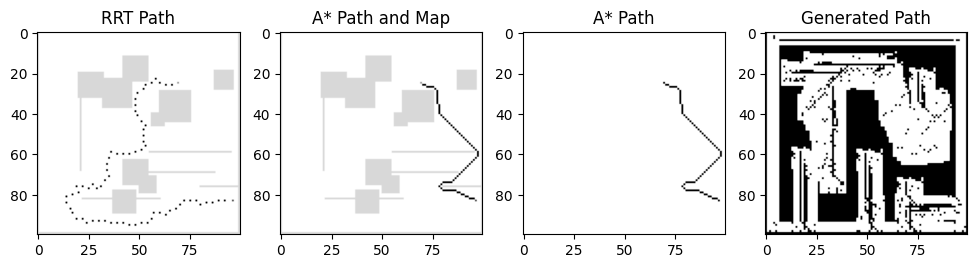

Epoch [201/1000], Total Steps: 6432, G Total Loss: 9.29092025756836, D Loss: 0.01364306453615427
Epoch [202/1000], Total Steps: 6464, G Total Loss: 6.713501930236816, D Loss: 0.01878541335463524
Epoch [203/1000], Total Steps: 6496, G Total Loss: 6.588435173034668, D Loss: 0.07371353358030319
Epoch [204/1000], Total Steps: 6528, G Total Loss: 10.200393676757812, D Loss: 0.14322596788406372
Epoch [205/1000], Total Steps: 6560, G Total Loss: 5.59316873550415, D Loss: 2.271862030029297
Epoch [206/1000], Total Steps: 6592, G Total Loss: 5.624248027801514, D Loss: 1.22245454788208
Epoch [207/1000], Total Steps: 6624, G Total Loss: 4.288976669311523, D Loss: 0.5907445549964905
Epoch [208/1000], Total Steps: 6656, G Total Loss: 5.165176868438721, D Loss: 0.13764972984790802
Epoch [209/1000], Total Steps: 6688, G Total Loss: 6.537944793701172, D Loss: 0.11583603918552399
Epoch [210/1000], Total Steps: 6720, G Total Loss: 4.982071876525879, D Loss: 0.11907684803009033
Checkpoint saved at epoch 2

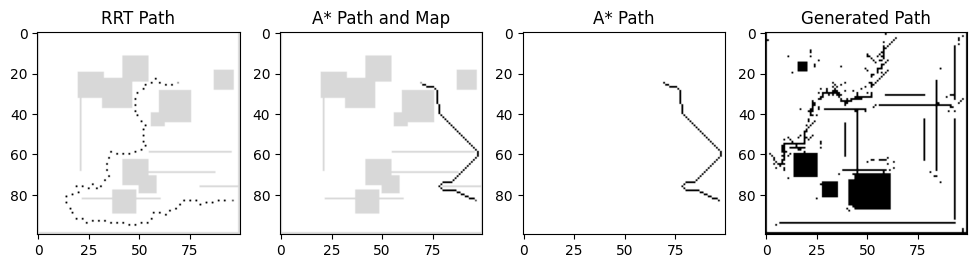

Epoch [211/1000], Total Steps: 6752, G Total Loss: 5.497888565063477, D Loss: 0.09277330338954926
Epoch [212/1000], Total Steps: 6784, G Total Loss: 5.404428958892822, D Loss: 0.05056425929069519
Epoch [213/1000], Total Steps: 6816, G Total Loss: 6.803304672241211, D Loss: 0.08161751925945282
Epoch [214/1000], Total Steps: 6848, G Total Loss: 4.045243263244629, D Loss: 0.3119577467441559
Epoch [215/1000], Total Steps: 6880, G Total Loss: 4.987731456756592, D Loss: 0.039218589663505554
Epoch [216/1000], Total Steps: 6912, G Total Loss: 7.67578649520874, D Loss: 0.03128841519355774
Epoch [217/1000], Total Steps: 6944, G Total Loss: 7.444835186004639, D Loss: 0.05796317011117935
Epoch [218/1000], Total Steps: 6976, G Total Loss: 5.262389659881592, D Loss: 0.10000711679458618
Epoch [219/1000], Total Steps: 7008, G Total Loss: 6.568645477294922, D Loss: 1.058225393295288
Epoch [220/1000], Total Steps: 7040, G Total Loss: 5.994503021240234, D Loss: 0.1019759327173233
Checkpoint saved at epoc

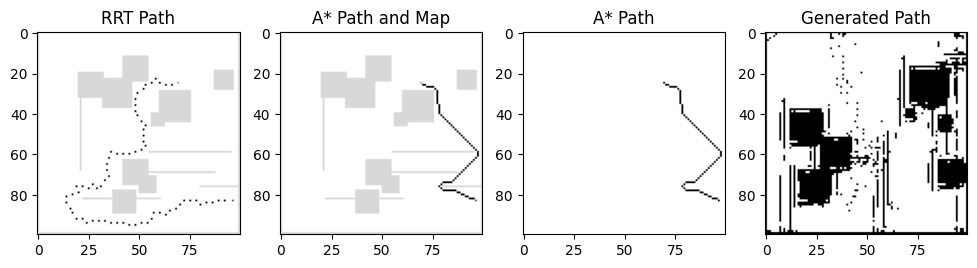

Epoch [221/1000], Total Steps: 7072, G Total Loss: 4.930146217346191, D Loss: 0.19735187292099
Epoch [222/1000], Total Steps: 7104, G Total Loss: 6.08541202545166, D Loss: 0.134847030043602
Epoch [223/1000], Total Steps: 7136, G Total Loss: 6.008019924163818, D Loss: 0.044294506311416626
Epoch [224/1000], Total Steps: 7168, G Total Loss: 6.220088005065918, D Loss: 0.04240494221448898
Epoch [225/1000], Total Steps: 7200, G Total Loss: 5.438961029052734, D Loss: 0.04680706560611725
Epoch [226/1000], Total Steps: 7232, G Total Loss: 5.609278678894043, D Loss: 0.050272874534130096
Epoch [227/1000], Total Steps: 7264, G Total Loss: 5.626528263092041, D Loss: 0.024114590138196945
Epoch [228/1000], Total Steps: 7296, G Total Loss: 6.165329933166504, D Loss: 0.028275396674871445
Epoch [229/1000], Total Steps: 7328, G Total Loss: 3.5833940505981445, D Loss: 0.02759031392633915
Epoch [230/1000], Total Steps: 7360, G Total Loss: 6.605250835418701, D Loss: 0.010417543351650238
Checkpoint saved at 

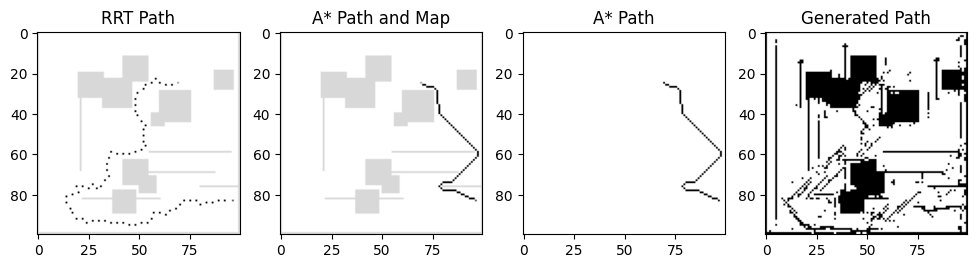

Epoch [231/1000], Total Steps: 7392, G Total Loss: 8.052669525146484, D Loss: 0.028904099017381668
Epoch [232/1000], Total Steps: 7424, G Total Loss: 7.379704475402832, D Loss: 0.013492448255419731
Epoch [233/1000], Total Steps: 7456, G Total Loss: 7.264719009399414, D Loss: 0.011953962966799736
Epoch [234/1000], Total Steps: 7488, G Total Loss: 9.125176429748535, D Loss: 0.01012544147670269
Epoch [235/1000], Total Steps: 7520, G Total Loss: 6.953675746917725, D Loss: 0.04435500502586365
Epoch [236/1000], Total Steps: 7552, G Total Loss: 6.776484966278076, D Loss: 0.012890443205833435
Epoch [237/1000], Total Steps: 7584, G Total Loss: 6.2718000411987305, D Loss: 0.025393614545464516
Epoch [238/1000], Total Steps: 7616, G Total Loss: 6.777005672454834, D Loss: 0.02366391196846962
Epoch [239/1000], Total Steps: 7648, G Total Loss: 6.8458380699157715, D Loss: 0.03801503777503967
Epoch [240/1000], Total Steps: 7680, G Total Loss: 8.229945182800293, D Loss: 0.01618422567844391
Checkpoint sa

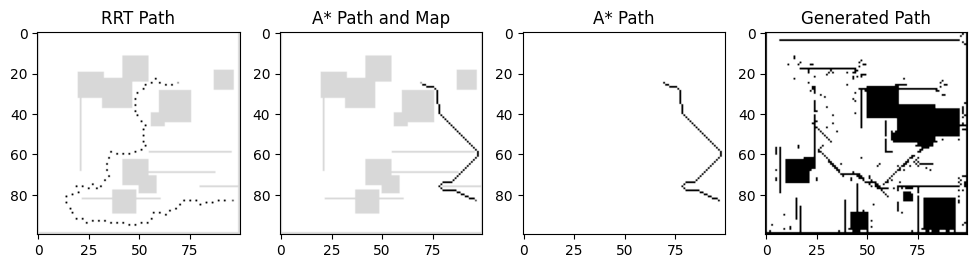

Epoch [241/1000], Total Steps: 7712, G Total Loss: 5.732332706451416, D Loss: 0.01436624675989151
Epoch [242/1000], Total Steps: 7744, G Total Loss: 7.533398628234863, D Loss: 0.011648677289485931
Epoch [243/1000], Total Steps: 7776, G Total Loss: 8.52515983581543, D Loss: 0.00937748234719038
Epoch [244/1000], Total Steps: 7808, G Total Loss: 8.05614948272705, D Loss: 0.008645063266158104
Epoch [245/1000], Total Steps: 7840, G Total Loss: 7.677541732788086, D Loss: 0.013960869051516056
Epoch [246/1000], Total Steps: 7872, G Total Loss: 8.531026840209961, D Loss: 0.0056907678954303265
Epoch [247/1000], Total Steps: 7904, G Total Loss: 9.115131378173828, D Loss: 0.011973433196544647
Epoch [248/1000], Total Steps: 7936, G Total Loss: 6.777257919311523, D Loss: 0.020700201392173767
Epoch [249/1000], Total Steps: 7968, G Total Loss: 6.7777099609375, D Loss: 0.018605422228574753
Epoch [250/1000], Total Steps: 8000, G Total Loss: 8.975058555603027, D Loss: 0.023110371083021164
Checkpoint save

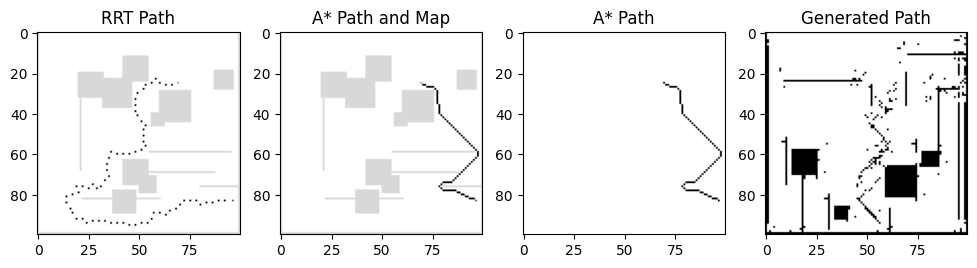

Epoch [251/1000], Total Steps: 8032, G Total Loss: 9.018926620483398, D Loss: 0.01139181386679411
Epoch [252/1000], Total Steps: 8064, G Total Loss: 6.665466785430908, D Loss: 0.005272109527140856
Epoch [253/1000], Total Steps: 8096, G Total Loss: 7.743946075439453, D Loss: 0.016304824501276016
Epoch [254/1000], Total Steps: 8128, G Total Loss: 5.766213417053223, D Loss: 0.005702612921595573
Epoch [255/1000], Total Steps: 8160, G Total Loss: 6.9209885597229, D Loss: 0.006993862800300121
Epoch [256/1000], Total Steps: 8192, G Total Loss: 4.322474479675293, D Loss: 0.007971523329615593
Epoch [257/1000], Total Steps: 8224, G Total Loss: 6.912746906280518, D Loss: 0.009603605605661869
Epoch [258/1000], Total Steps: 8256, G Total Loss: 6.656493186950684, D Loss: 0.011784324422478676
Epoch [259/1000], Total Steps: 8288, G Total Loss: 8.071988105773926, D Loss: 0.004227459896355867
Epoch [260/1000], Total Steps: 8320, G Total Loss: 8.510297775268555, D Loss: 0.015635747462511063
Checkpoint sa

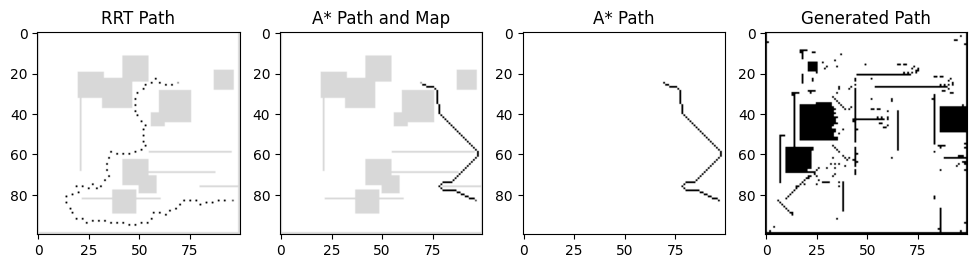

Epoch [261/1000], Total Steps: 8352, G Total Loss: 8.177380561828613, D Loss: 0.01477002166211605
Epoch [262/1000], Total Steps: 8384, G Total Loss: 7.6251540184021, D Loss: 0.015522345900535583
Epoch [263/1000], Total Steps: 8416, G Total Loss: 8.568548202514648, D Loss: 0.008761463686823845
Epoch [264/1000], Total Steps: 8448, G Total Loss: 9.065305709838867, D Loss: 0.016375470906496048
Epoch [265/1000], Total Steps: 8480, G Total Loss: 9.030004501342773, D Loss: 0.010057678446173668
Epoch [266/1000], Total Steps: 8512, G Total Loss: 8.180211067199707, D Loss: 0.006987352389842272
Epoch [267/1000], Total Steps: 8544, G Total Loss: 9.011658668518066, D Loss: 0.027350539341568947
Epoch [268/1000], Total Steps: 8576, G Total Loss: 3.7636306285858154, D Loss: 0.027047721669077873
Epoch [269/1000], Total Steps: 8608, G Total Loss: 9.299115180969238, D Loss: 0.004578040447086096
Epoch [270/1000], Total Steps: 8640, G Total Loss: 9.081382751464844, D Loss: 0.009786988608539104
Checkpoint s

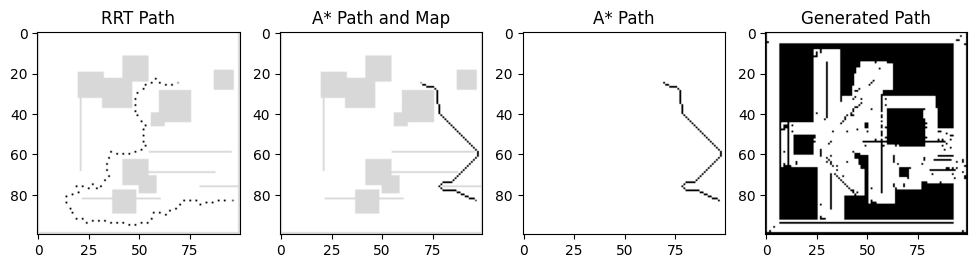

Epoch [271/1000], Total Steps: 8672, G Total Loss: 8.006211280822754, D Loss: 0.007881351746618748
Epoch [272/1000], Total Steps: 8704, G Total Loss: 9.091669082641602, D Loss: 0.017708072438836098
Epoch [273/1000], Total Steps: 8736, G Total Loss: 8.769619941711426, D Loss: 0.010272023268043995
Epoch [274/1000], Total Steps: 8768, G Total Loss: 9.005203247070312, D Loss: 0.003977965097874403
Epoch [275/1000], Total Steps: 8800, G Total Loss: 9.954185485839844, D Loss: 0.020697351545095444
Epoch [276/1000], Total Steps: 8832, G Total Loss: 7.146061897277832, D Loss: 0.005385606549680233
Epoch [277/1000], Total Steps: 8864, G Total Loss: 9.19790267944336, D Loss: 0.009550392627716064
Epoch [278/1000], Total Steps: 8896, G Total Loss: 9.195446014404297, D Loss: 0.019479025155305862
Epoch [279/1000], Total Steps: 8928, G Total Loss: 9.21678352355957, D Loss: 0.01766096241772175
Epoch [280/1000], Total Steps: 8960, G Total Loss: 9.441411018371582, D Loss: 0.012264283373951912
Checkpoint sa

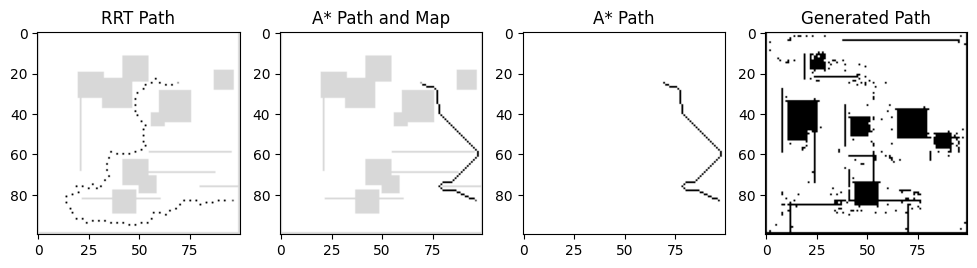

Epoch [281/1000], Total Steps: 8992, G Total Loss: 5.924874782562256, D Loss: 0.008333195932209492
Epoch [282/1000], Total Steps: 9024, G Total Loss: 7.53645133972168, D Loss: 0.018788352608680725
Epoch [283/1000], Total Steps: 9056, G Total Loss: 8.6434907913208, D Loss: 0.01279620360583067
Epoch [284/1000], Total Steps: 9088, G Total Loss: 9.3250093460083, D Loss: 0.004691039677709341
Epoch [285/1000], Total Steps: 9120, G Total Loss: 6.42699670791626, D Loss: 0.0028115396853536367
Epoch [286/1000], Total Steps: 9152, G Total Loss: 8.382930755615234, D Loss: 0.005049349740147591
Epoch [287/1000], Total Steps: 9184, G Total Loss: 8.954302787780762, D Loss: 0.007893295027315617
Epoch [288/1000], Total Steps: 9216, G Total Loss: 9.97591495513916, D Loss: 0.008480697870254517
Epoch [289/1000], Total Steps: 9248, G Total Loss: 10.171658515930176, D Loss: 0.027404069900512695
Epoch [290/1000], Total Steps: 9280, G Total Loss: 9.673757553100586, D Loss: 0.006178062409162521
Checkpoint saved

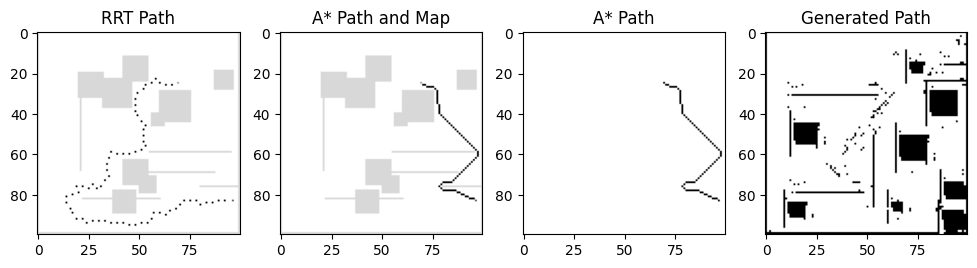

Epoch [291/1000], Total Steps: 9312, G Total Loss: 9.39866828918457, D Loss: 0.02735385112464428
Epoch [292/1000], Total Steps: 9344, G Total Loss: 10.250505447387695, D Loss: 0.006104476749897003
Epoch [293/1000], Total Steps: 9376, G Total Loss: 10.212525367736816, D Loss: 0.005359558388590813
Epoch [294/1000], Total Steps: 9408, G Total Loss: 10.317115783691406, D Loss: 0.007390846498310566
Epoch [295/1000], Total Steps: 9440, G Total Loss: 8.244758605957031, D Loss: 0.007170419674366713
Epoch [296/1000], Total Steps: 9472, G Total Loss: 10.025662422180176, D Loss: 0.004991704598069191
Epoch [297/1000], Total Steps: 9504, G Total Loss: 9.875139236450195, D Loss: 0.007554190699011087
Epoch [298/1000], Total Steps: 9536, G Total Loss: 9.458724975585938, D Loss: 0.0364009253680706
Epoch [299/1000], Total Steps: 9568, G Total Loss: 9.195335388183594, D Loss: 0.09485702216625214
Epoch [300/1000], Total Steps: 9600, G Total Loss: 9.203163146972656, D Loss: 0.009095899760723114
Checkpoint 

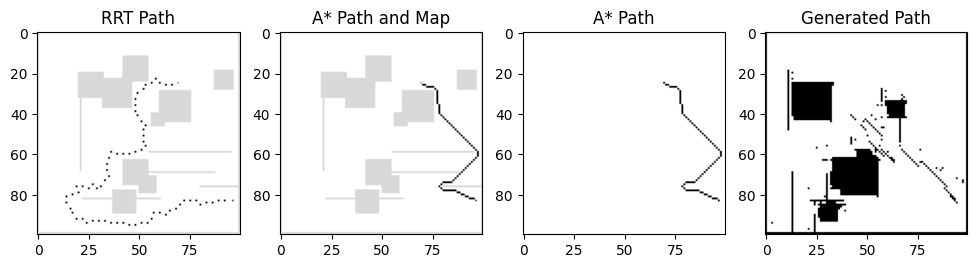

Epoch [301/1000], Total Steps: 9632, G Total Loss: 8.689481735229492, D Loss: 0.014821535907685757
Epoch [302/1000], Total Steps: 9664, G Total Loss: 10.262371063232422, D Loss: 0.07980681210756302
Epoch [303/1000], Total Steps: 9696, G Total Loss: 8.405963897705078, D Loss: 0.008376501500606537
Epoch [304/1000], Total Steps: 9728, G Total Loss: 8.869349479675293, D Loss: 0.011911915615200996
Epoch [305/1000], Total Steps: 9760, G Total Loss: 8.428807258605957, D Loss: 0.006967116147279739
Epoch [306/1000], Total Steps: 9792, G Total Loss: 8.363202095031738, D Loss: 0.01822611875832081
Epoch [307/1000], Total Steps: 9824, G Total Loss: 9.373647689819336, D Loss: 0.009466767311096191
Epoch [308/1000], Total Steps: 9856, G Total Loss: 8.06904411315918, D Loss: 0.005106157623231411
Epoch [309/1000], Total Steps: 9888, G Total Loss: 10.953287124633789, D Loss: 0.11503386497497559
Best Model Saved at Gen_Loss: 1.7277871370315552.
Epoch [310/1000], Total Steps: 9920, G Total Loss: 5.44260740

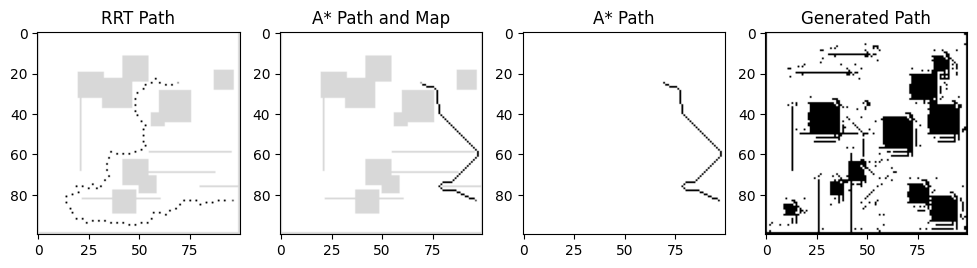

Epoch [311/1000], Total Steps: 9952, G Total Loss: 2.1878552436828613, D Loss: 0.20751437544822693
Epoch [312/1000], Total Steps: 9984, G Total Loss: 7.490391731262207, D Loss: 0.08005859702825546
Epoch [313/1000], Total Steps: 10016, G Total Loss: 5.272563934326172, D Loss: 0.21599839627742767
Epoch [314/1000], Total Steps: 10048, G Total Loss: 6.632351398468018, D Loss: 0.2805962860584259
Epoch [315/1000], Total Steps: 10080, G Total Loss: 6.813353538513184, D Loss: 0.23732821643352509
Epoch [316/1000], Total Steps: 10112, G Total Loss: 2.695554733276367, D Loss: 0.6601110100746155
Epoch [317/1000], Total Steps: 10144, G Total Loss: 4.72643518447876, D Loss: 0.08540500700473785
Epoch [318/1000], Total Steps: 10176, G Total Loss: 8.44364070892334, D Loss: 0.5309404134750366
Epoch [319/1000], Total Steps: 10208, G Total Loss: 7.706312656402588, D Loss: 0.20073488354682922
Epoch [320/1000], Total Steps: 10240, G Total Loss: 5.976101398468018, D Loss: 0.19522301852703094
Checkpoint saved

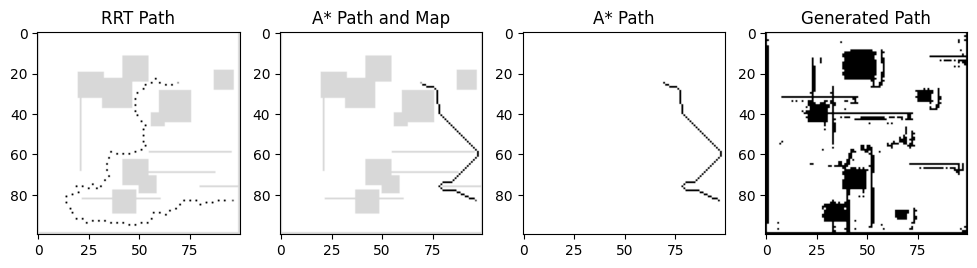

Epoch [321/1000], Total Steps: 10272, G Total Loss: 3.9827933311462402, D Loss: 0.1223764717578888
Epoch [322/1000], Total Steps: 10304, G Total Loss: 2.3502542972564697, D Loss: 0.519722044467926
Epoch [323/1000], Total Steps: 10336, G Total Loss: 7.269312381744385, D Loss: 0.07406601309776306
Epoch [324/1000], Total Steps: 10368, G Total Loss: 7.207974433898926, D Loss: 0.01797800324857235
Epoch [325/1000], Total Steps: 10400, G Total Loss: 8.236213684082031, D Loss: 0.044087283313274384
Epoch [326/1000], Total Steps: 10432, G Total Loss: 7.990131855010986, D Loss: 0.08226393163204193
Epoch [327/1000], Total Steps: 10464, G Total Loss: 6.228977203369141, D Loss: 0.01908697932958603
Epoch [328/1000], Total Steps: 10496, G Total Loss: 6.765202522277832, D Loss: 0.3998061716556549
Epoch [329/1000], Total Steps: 10528, G Total Loss: 5.090845584869385, D Loss: 0.06057767570018768
Epoch [330/1000], Total Steps: 10560, G Total Loss: 3.7420969009399414, D Loss: 0.02734607458114624
Checkpoint

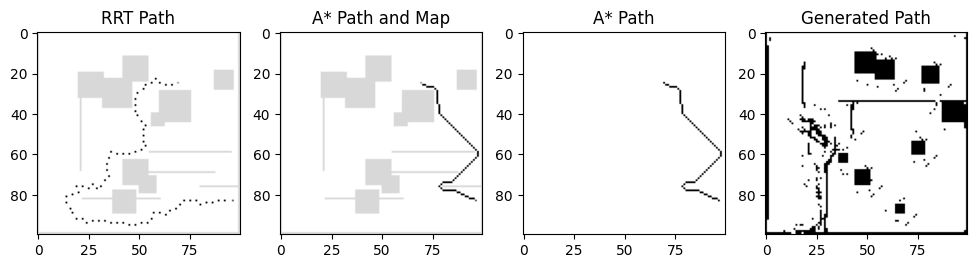

Epoch [331/1000], Total Steps: 10592, G Total Loss: 6.409183025360107, D Loss: 0.04509051889181137
Epoch [332/1000], Total Steps: 10624, G Total Loss: 6.932076930999756, D Loss: 0.029896287247538567
Epoch [333/1000], Total Steps: 10656, G Total Loss: 8.509259223937988, D Loss: 0.03688400611281395
Epoch [334/1000], Total Steps: 10688, G Total Loss: 8.097530364990234, D Loss: 0.05169826000928879
Epoch [335/1000], Total Steps: 10720, G Total Loss: 8.323665618896484, D Loss: 0.0195386353880167
Epoch [336/1000], Total Steps: 10752, G Total Loss: 8.197099685668945, D Loss: 0.0459277369081974
Epoch [337/1000], Total Steps: 10784, G Total Loss: 8.124102592468262, D Loss: 0.21717435121536255
Epoch [338/1000], Total Steps: 10816, G Total Loss: 8.733516693115234, D Loss: 0.04823596775531769
Epoch [339/1000], Total Steps: 10848, G Total Loss: 7.068585395812988, D Loss: 0.8702852725982666
Epoch [340/1000], Total Steps: 10880, G Total Loss: 9.200693130493164, D Loss: 0.07586109638214111
Checkpoint s

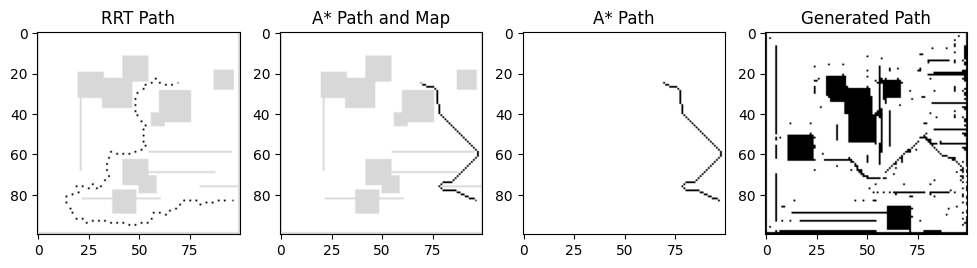

Epoch [341/1000], Total Steps: 10912, G Total Loss: 4.701068878173828, D Loss: 0.06813599169254303
Epoch [342/1000], Total Steps: 10944, G Total Loss: 9.611380577087402, D Loss: 0.041411805897951126
Epoch [343/1000], Total Steps: 10976, G Total Loss: 10.784510612487793, D Loss: 0.03809748962521553
Epoch [344/1000], Total Steps: 11008, G Total Loss: 3.5590524673461914, D Loss: 0.01283234916627407
Epoch [345/1000], Total Steps: 11040, G Total Loss: 7.602396488189697, D Loss: 0.04752028360962868
Epoch [346/1000], Total Steps: 11072, G Total Loss: 6.53810977935791, D Loss: 0.021619917824864388
Epoch [347/1000], Total Steps: 11104, G Total Loss: 9.122819900512695, D Loss: 0.021578045561909676
Epoch [348/1000], Total Steps: 11136, G Total Loss: 9.672508239746094, D Loss: 0.022368591278791428
Epoch [349/1000], Total Steps: 11168, G Total Loss: 8.909153938293457, D Loss: 0.009577455930411816
Epoch [350/1000], Total Steps: 11200, G Total Loss: 9.991585731506348, D Loss: 0.010868974030017853
Che

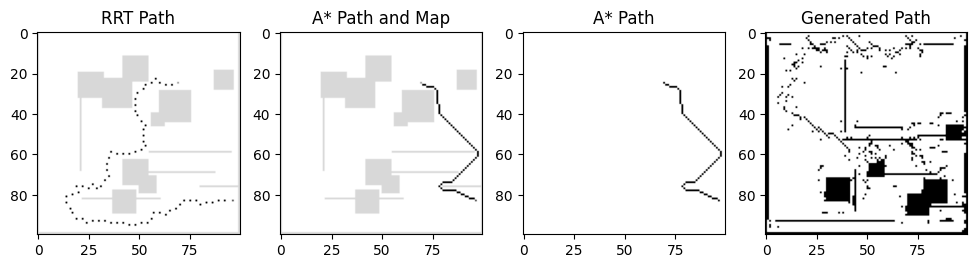

Epoch [351/1000], Total Steps: 11232, G Total Loss: 9.69686508178711, D Loss: 0.009108968079090118
Epoch [352/1000], Total Steps: 11264, G Total Loss: 9.623702049255371, D Loss: 0.0230606347322464
Epoch [353/1000], Total Steps: 11296, G Total Loss: 8.626968383789062, D Loss: 0.008192366920411587
Epoch [354/1000], Total Steps: 11328, G Total Loss: 8.3330717086792, D Loss: 0.004523386247456074
Epoch [355/1000], Total Steps: 11360, G Total Loss: 9.340469360351562, D Loss: 0.004710551351308823
Epoch [356/1000], Total Steps: 11392, G Total Loss: 8.160701751708984, D Loss: 0.060047224164009094
Epoch [357/1000], Total Steps: 11424, G Total Loss: 7.846372127532959, D Loss: 0.01831251196563244
Epoch [358/1000], Total Steps: 11456, G Total Loss: 8.177911758422852, D Loss: 0.00652348855510354
Epoch [359/1000], Total Steps: 11488, G Total Loss: 3.3353772163391113, D Loss: 0.01201731525361538
Epoch [360/1000], Total Steps: 11520, G Total Loss: 7.037564277648926, D Loss: 0.1087535098195076
Checkpoin

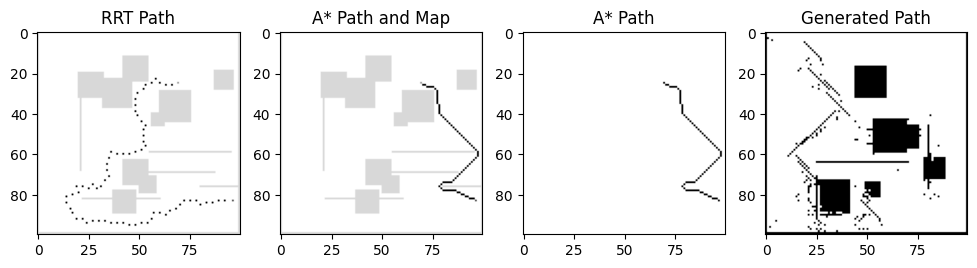

Epoch [361/1000], Total Steps: 11552, G Total Loss: 6.404509544372559, D Loss: 1.3340914249420166
Epoch [362/1000], Total Steps: 11584, G Total Loss: 4.845676422119141, D Loss: 0.06962060928344727
Epoch [363/1000], Total Steps: 11616, G Total Loss: 8.869413375854492, D Loss: 0.2114141583442688
Epoch [364/1000], Total Steps: 11648, G Total Loss: 10.481788635253906, D Loss: 0.10098300874233246
Epoch [365/1000], Total Steps: 11680, G Total Loss: 7.392230987548828, D Loss: 0.02406660094857216
Epoch [366/1000], Total Steps: 11712, G Total Loss: 8.262218475341797, D Loss: 0.07087286561727524
Epoch [367/1000], Total Steps: 11744, G Total Loss: 6.95660400390625, D Loss: 0.021732060238718987
Epoch [368/1000], Total Steps: 11776, G Total Loss: 4.200371265411377, D Loss: 0.32622745633125305
Epoch [369/1000], Total Steps: 11808, G Total Loss: 8.504740715026855, D Loss: 0.038386549800634384
Epoch [370/1000], Total Steps: 11840, G Total Loss: 8.47936725616455, D Loss: 0.03808165714144707
Checkpoint 

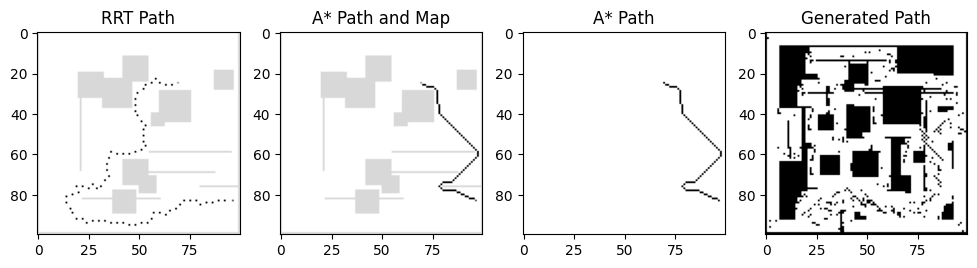

Epoch [371/1000], Total Steps: 11872, G Total Loss: 9.938267707824707, D Loss: 0.08074895292520523
Epoch [372/1000], Total Steps: 11904, G Total Loss: 7.967358589172363, D Loss: 0.045810192823410034
Epoch [373/1000], Total Steps: 11936, G Total Loss: 7.29361629486084, D Loss: 0.04045119136571884
Epoch [374/1000], Total Steps: 11968, G Total Loss: 6.731939792633057, D Loss: 0.03478163480758667
Epoch [375/1000], Total Steps: 12000, G Total Loss: 8.02250862121582, D Loss: 0.06305522471666336
Epoch [376/1000], Total Steps: 12032, G Total Loss: 7.532815456390381, D Loss: 0.025652796030044556
Epoch [377/1000], Total Steps: 12064, G Total Loss: 9.238945960998535, D Loss: 0.026827549561858177
Epoch [378/1000], Total Steps: 12096, G Total Loss: 9.467042922973633, D Loss: 0.009174061939120293
Epoch [379/1000], Total Steps: 12128, G Total Loss: 10.492446899414062, D Loss: 0.015061435289680958
Epoch [380/1000], Total Steps: 12160, G Total Loss: 9.717855453491211, D Loss: 0.010173882357776165
Check

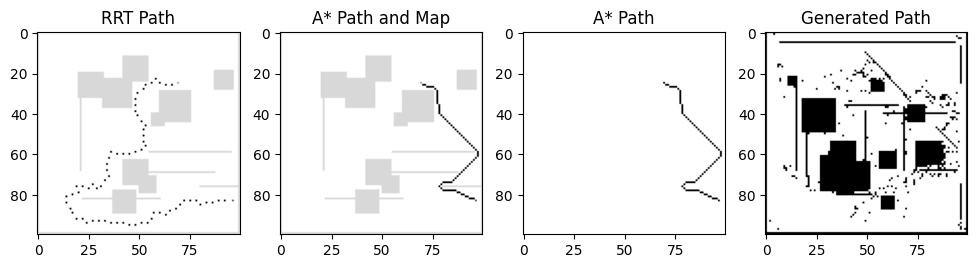

Epoch [381/1000], Total Steps: 12192, G Total Loss: 7.879970073699951, D Loss: 0.016959667205810547
Epoch [382/1000], Total Steps: 12224, G Total Loss: 9.84360122680664, D Loss: 0.014894450083374977
Epoch [383/1000], Total Steps: 12256, G Total Loss: 9.736348152160645, D Loss: 0.010288182646036148
Epoch [384/1000], Total Steps: 12288, G Total Loss: 7.2418622970581055, D Loss: 0.01348167471587658
Epoch [385/1000], Total Steps: 12320, G Total Loss: 9.680696487426758, D Loss: 0.0518895648419857
Epoch [386/1000], Total Steps: 12352, G Total Loss: 9.598848342895508, D Loss: 0.006924943067133427
Epoch [387/1000], Total Steps: 12384, G Total Loss: 7.864206314086914, D Loss: 0.0075207483023405075
Epoch [388/1000], Total Steps: 12416, G Total Loss: 8.287125587463379, D Loss: 0.008904187008738518
Epoch [389/1000], Total Steps: 12448, G Total Loss: 8.434041023254395, D Loss: 0.015264059416949749
Epoch [390/1000], Total Steps: 12480, G Total Loss: 7.457711219787598, D Loss: 0.012555455788969994
Ch

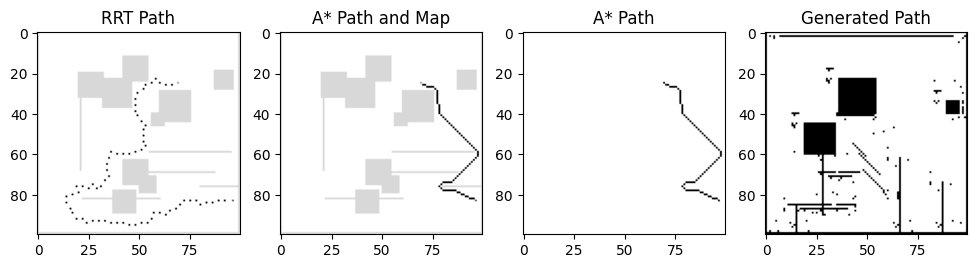

Epoch [391/1000], Total Steps: 12512, G Total Loss: 8.789714813232422, D Loss: 0.017048275098204613
Epoch [392/1000], Total Steps: 12544, G Total Loss: 8.531112670898438, D Loss: 0.009082301519811153
Epoch [393/1000], Total Steps: 12576, G Total Loss: 7.929945468902588, D Loss: 0.0034141656942665577
Epoch [394/1000], Total Steps: 12608, G Total Loss: 9.33802604675293, D Loss: 0.016613580286502838
Epoch [395/1000], Total Steps: 12640, G Total Loss: 8.57748794555664, D Loss: 0.02062389999628067
Epoch [396/1000], Total Steps: 12672, G Total Loss: 10.723448753356934, D Loss: 0.03622632473707199
Epoch [397/1000], Total Steps: 12704, G Total Loss: 9.26953125, D Loss: 0.016599509865045547
Epoch [398/1000], Total Steps: 12736, G Total Loss: 8.426700592041016, D Loss: 0.0801582783460617
Epoch [399/1000], Total Steps: 12768, G Total Loss: 9.235173225402832, D Loss: 0.004959121346473694
Epoch [400/1000], Total Steps: 12800, G Total Loss: 10.963726997375488, D Loss: 0.009026648476719856
Checkpoint

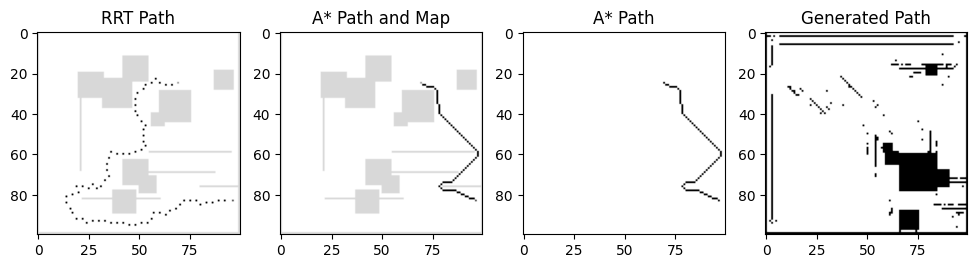

Epoch [401/1000], Total Steps: 12832, G Total Loss: 8.921902656555176, D Loss: 0.061592839658260345
Epoch [402/1000], Total Steps: 12864, G Total Loss: 9.799924850463867, D Loss: 0.03161698952317238
Epoch [403/1000], Total Steps: 12896, G Total Loss: 9.736645698547363, D Loss: 0.006714716553688049
Epoch [404/1000], Total Steps: 12928, G Total Loss: 9.427263259887695, D Loss: 0.008900540880858898
Epoch [405/1000], Total Steps: 12960, G Total Loss: 9.100410461425781, D Loss: 0.010412820614874363
Epoch [406/1000], Total Steps: 12992, G Total Loss: 9.192699432373047, D Loss: 0.005328957922756672
Epoch [407/1000], Total Steps: 13024, G Total Loss: 9.510952949523926, D Loss: 0.02522822469472885
Epoch [408/1000], Total Steps: 13056, G Total Loss: 6.700713634490967, D Loss: 0.004257767926901579
Epoch [409/1000], Total Steps: 13088, G Total Loss: 9.434215545654297, D Loss: 0.00970566738396883
Epoch [410/1000], Total Steps: 13120, G Total Loss: 10.276053428649902, D Loss: 0.0046707079745829105
C

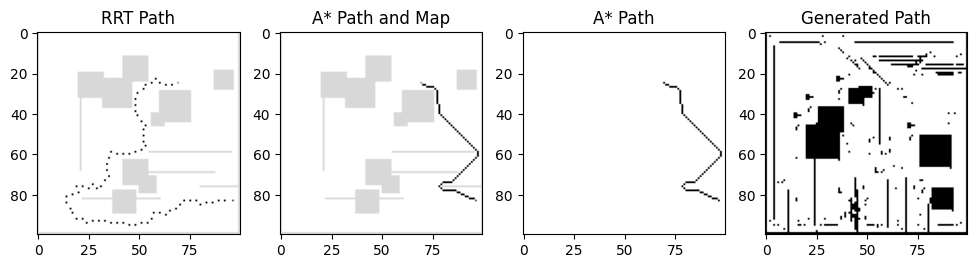

Epoch [411/1000], Total Steps: 13152, G Total Loss: 9.398427963256836, D Loss: 0.004362825304269791
Epoch [412/1000], Total Steps: 13184, G Total Loss: 10.761064529418945, D Loss: 0.026248719543218613
Epoch [413/1000], Total Steps: 13216, G Total Loss: 9.808309555053711, D Loss: 0.03307170420885086
Epoch [414/1000], Total Steps: 13248, G Total Loss: 10.001224517822266, D Loss: 0.00715226773172617
Epoch [415/1000], Total Steps: 13280, G Total Loss: 8.452324867248535, D Loss: 0.0685764029622078


KeyboardInterrupt: ignored

In [ ]:
# Parameters
num_epochs = 1000 # Number of epochs for training
input_channels = 1  # Assuming grayscale input maps
output_channels = 1  # Assuming grayscale output maps

# Initialize your models
generator = UNetGenerator(input_channels, output_channels).to(device)
discriminator = Discriminator().to(device)

# Define optimizers for both generator and discriminator
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Keep track of minimum loss for model saving
best_g_total_loss = float('inf')

# TensorBoard setup
log_dir = 'runs/GAN_experiment'
os.makedirs(log_dir, exist_ok=True)
# Setup TensorBoard writer
writer = SummaryWriter(log_dir)

# Checkpointing functions
def save_checkpoint(model, optimizer, filename):
    """
    Save a model checkpoint.

    Parameters:
    - model: PyTorch model to be saved
    - optimizer: Optimizer state to be saved
    - filename: Path where the checkpoint will be saved
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

total_steps = 0

for epoch in range(num_epochs):
    for step, data in enumerate(dataloader):
        rrt_modified_maps = data['rrt_modified_map'].to(device)
        astar_modified_maps = data['astar_modified_map'].to(device)
        astar_path_maps = data['astar_path_map'].to(device)

        # Generate maps using the generator
        fake_astar_maps, fake_astar_maps_binary, fake_astar_maps_logits = generator(rrt_modified_maps)

        # Train Discriminator
        if step % 10 == 0:  # Update discriminator conditionally
            disc_optimizer.zero_grad()
            # Get discriminator outputs for real and fake data
            disc_real_output = discriminator(rrt_modified_maps, astar_modified_maps)
            disc_fake_output = discriminator(rrt_modified_maps, fake_astar_maps_logits.detach())
            # Calculate total discriminator loss
            disc_loss = discriminator_loss(disc_real_output, disc_fake_output)
            # Backward pass and optimizer step
            disc_loss.backward()
            disc_optimizer.step()

        # Train Generator
        gen_optimizer.zero_grad()
        disc_fake_output = discriminator(rrt_modified_maps, fake_astar_maps_logits)
        gen_loss = generator_loss(disc_fake_output, fake_astar_maps_logits, astar_path_maps)
        gen_loss.backward()
        gen_optimizer.step()

        total_steps += 1  # Increment total steps

        if step % 100 == 0:
            # Instead of printing every 100 steps, you'll log to TensorBoard
            writer.add_scalar('Generator Total Loss', gen_loss.item(), global_step=total_steps)
            writer.add_scalar('Discriminator Loss', disc_loss.item(), global_step=total_steps)

        # Save model checkpoints if new minimum generator loss is achieved
        if gen_loss.item() < best_g_total_loss:
            best_g_total_loss = gen_loss.item()
            save_checkpoint(generator, gen_optimizer, 'best_generator_checkpoint.pth')
            save_checkpoint(discriminator, disc_optimizer, 'best_discriminator_checkpoint.pth')
            print(f"Best Model Saved at Gen_Loss: {best_g_total_loss}.")

    # Print and log at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Steps: {total_steps}, G Total Loss: {gen_loss.item()}, D Loss: {disc_loss.item()}")
    writer.add_scalar('Generator Total Loss', gen_loss.item(), global_step=total_steps)
    writer.add_scalar('Discriminator Loss', disc_loss.item(), global_step=total_steps)


    # Save checkpoint every 10 epochs, not labeled as best
    if (epoch + 1) % 10 == 0:
        checkpoint_name_generator = f'checkpoint_generator.pth'
        checkpoint_name_discriminator = f'checkpoint_discriminator_epoch.pth'
        save_checkpoint(generator, gen_optimizer, checkpoint_name_generator)
        save_checkpoint(discriminator, disc_optimizer, checkpoint_name_discriminator)
        print(f"Checkpoint saved at epoch {epoch+1}.")

        # Generate and plot maps for visualization
        with torch.no_grad():
            generated_output, generated_output_binary, _ = generator(rrt_modified_maps[:1])  # Take the first map for visualization
        plot_maps(rrt_modified_maps[0], astar_modified_maps[0], astar_path_maps[0], generated_output_binary)

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.transformer = nn.Transformer(d_model=input_size, nhead=4, num_encoder_layers=3, num_decoder_layers=3)
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, src, mask=None):
        # src: [batch_size, seq_len, input_size]
        transformer_output = self.transformer(src, src, src_key_padding_mask=mask)
        output = self.fc(transformer_output)
        return output

In [ ]:
generator = Generator(input_size=100, hidden_size=128, output_size=50)
# Example input (dummy data)
src = torch.rand(4, 50, 100)  # [batch_size, seq_len, input_size]
mask = torch.rand(4, 50).bool()  # Random mask for example

# Forward pass
generated_path = generator(src, mask)
generated_path

c:\Users\jjaso\anaconda3\envs\plan2planenv\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


AssertionError: expecting key_padding_mask shape of (50, 4), but got torch.Size([4, 50])